# Prelude

To change things up, in this tutorial we are going to work with [McCracken's Monthly and Quarterly Databases for Macroeconomic Research](https://research.stlouisfed.org/econ/mccracken/fred-databases/). The databases offer real-time vintages on many US macroeconomic variables. For those of you who are not familiar, there is an important difference (among other things) between, e.g., financial market data and macroeconomic data:
* Data on stock prices for example is almost immediately available and "fixed". It is simple a snapshot of stock market prices at a given point in time. 
* Macroeconomic indicators such as GDP, however, are complicated and costly to compile. They are estimates of the true economic activity and often revised sometimes even years later when new data comes in. Thus past values are subject to change. A so-called data vintage is the current value of the series that is available at that point in time (but might be revised later). A real-time database stores all of these values and thus allows to monitor how a given estimate of, e.g., GDP might have changed over time. Macroeconomic forecasting models that only use real-time data (data that would have been available/known in the past at the time a specific forecast was made) are hence called real-time forecasting models.  


This tutorial is split in two parts:
* In the first part of the tutorial we are going to work with Lasso. We are going to work with the monthly dataset and attempt to predict inflation.
* In the second part of the tutorial, we are going to work with Lasso, Ridge regression, and PCA. As an exercise we are going to predict recessions. For this purpose, we are going to use the quarterly dataset instead (GDP is only available at quarterly frequency).

Key learning objectives are:
* Lasso & Ridge: What's the difference?
* Principal Component Analysis: Sparse vs. dense data
* More on in-sample vs. out-of-sample-predictions 
* Lasso in causal inference? A brief primer on Double Debiased Machine Learning
* A bit on model stability
* ROC curves

*As before, note that this exercise is again highly stylized. For example, we are going to look at cross-sectional predictions of GDP. In reality, predicting future GDP growth is a more important and interesting exercise.*



# Lecture 2 - Part 1
### 1.0 Setup


In [1]:
# import Python packages
%matplotlib inline  
import pandas as pd 
import numpy as np  
import scipy as sp 
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
from IPython.display import Image
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

### 1.1 Data Cleaning
Before we jump into the exercise, we need to do some basic data cleaning. In this case what we care about is eliminating stochastic and deterministic trends in the data. Luckily, the database already suggests appropriate data transformation. The transformation codes are stored in row `transform` which I save in variable `df_transform` below. 

In [2]:
# read-in the .csv file
df = pd.read_csv('current_M.csv')

# store the transformation information for later
df_transform = df.iloc[0,:]

# delete the first row as they contain meta-information
df = df.iloc[1:,:]

# transform the date series into datetime values
df['sasdate'] = df['sasdate'].astype('datetime64[ns]') 

# set the dates as new index
df = df.set_index('sasdate')

# display the data 
df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,21.9882,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1959-02-01,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,22.1036,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
1959-03-01,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,22.5365,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
1959-04-01,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,22.6807,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
1959-05-01,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,23.1424,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


Specifically, `df_transform` contains numbers from 1 to 7 that denote a method of transformation that is suggested for the specific series:

In [3]:
df_transform

sasdate            Transform:
RPI                       5.0
W875RX1                   5.0
DPCERA3M086SBEA           5.0
CMRMTSPLx                 5.0
                      ...    
MZMSL                     6.0
DTCOLNVHFNM               6.0
DTCTHFNM                  6.0
INVEST                    6.0
VXOCLSx                   1.0
Name: 0, Length: 129, dtype: object

All we have to do now is write a code snippet that transforms each series according to its designated code:

In [4]:
# create an emptyh copy of the dataframe, where the indices and column names are the same
df_trans = pd.DataFrame(index=df.index, columns=df.columns)

# loop over the columns of the dataframe 
for i in range(0,df.shape[1]):
    
    # transform data to 'levels', i.e. no change
    if df_transform[i+1] == 1:
        df_trans[df.columns[i]] = df[df.columns[i]]
    
    # transform data to 'first differences'
    elif df_transform[i+1] == 2:
        df_trans[df.columns[i]] = df[df.columns[i]].diff()
    
    # transform data to 'second differences'
    elif df_transform[i+1] == 3:
        df_trans[df.columns[i]] = df[df.columns[i]].diff(periods=2)
        
    # transform data to 'log-levels'
    elif df_transform[i+1] == 4:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]])
        
    # transform data to 'log-differences'
    elif df_transform[i+1] == 5:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]]).diff()
    
    # transform data to 'second log-differences'
    elif df_transform[i+1] == 6:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]]).diff(periods=2)
    
    # transform data to 'percentage changes'
    elif df_transform[i+1] == 7:
        df_trans[df.columns[i]] = df[df.columns[i]].pct_change()

# display the transformed data
df_trans.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,0.003934,0.003576,0.010350,0.007400,0.007310,0.019395,0.013406,0.008629,0.007308,0.005235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,0.006431,0.007374,0.009394,-0.003416,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,0.003252,0.009346,0.000000,0.014599,NaN,0.009053,0.004929,0.004138,-0.030921,NaN
1959-04-01,0.006498,0.007019,-0.003576,0.019929,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,0.005348,0.009302,0.004057,0.014528,NaN,0.007580,0.021992,0.015011,-0.020784,NaN
1959-05-01,0.005826,0.006629,0.011984,0.006796,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,0.005164,0.009259,0.012171,0.004819,NaN,0.009686,0.036955,0.023766,-0.011197,NaN


Due to differencing the data, we lost observations. Moreover, the dataset contains a row of missing values at the end of the sample. We will also delete this row. To make the process more efficient, we can utilize logical operators that return Boolean values. I am not using .dropna() here, because the data might contain time series that start only later in the sample. Dropping all rows containing NaNs, would thus reduce the sample size. Since we don't have time to cover more elaborate techniques of dealing with missing data in this tutorial, we will simply drop these variables from our set. For that we can use `.dropna(axis='columns')`. 

As a word of caution, sometimes data series are subject to so-called publication lags. This means that the value of a time-series for e.g. January 2021 might only be available at a later point in time, e.g. February or March. Reasons for this can be related to the process of compiling certain time-series that can be quite demanding for the statistics agencies that are involved. Thus, additional missing values can result at the end of the sample for certain variables. The resulting "bumpy" pattern at the bottom om the sample is also referred to as "ragged-edge". Many techniques exist for dealing with this phenomenon, most of which we can't cover here. To keep things simple, we will simply drop an additional row. Variables that have longer publication lags will simply be dropped in the process of calling `.dropna(axis='columns')`. 

To make things a little more involved, let's have the code detect how many observations must be dropped at the beginning of the sample. For this purpose, we can exploit the transformation codes:

In [5]:
# here I simply use the df_transform series and the fact that Python reads if statements from top to bottom.
# Checking for two missing values must hence be done first.

# check whether the transformation code contains 2nd differences or 2nd log-differences
if 3 in df_transform.unique() or 6 in df_transform.unique():
    
    # print a message
    print('two missing values at the beginning detected. Deleted the first two rows.')
    # drop the first two observations
    df_trans = df_trans.iloc[2:,:]

# check whether the transformation code contains 1st differences or 1st log-differences or pct. changes
elif 2 in df_transform.unique() or 5 in df_transform.unique() or 7 in df_transform.unique():
    
    # print a meassage
    print('one missing values at the beginning detected. Deleted the first row.')
    
    # drop the first observation
    df_trans = df_trans.iloc[1:,:]

# drop missing values at the end of the sample     
df_trans = df_trans.iloc[:-2,:]

df_trans

two missing values at the beginning detected. Deleted the first two rows.


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-03-01,0.006431,0.007374,0.009394,-0.003416,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,0.003252,0.009346,0.000000,0.014599,NaN,0.009053,0.004929,0.004138,-0.030921,NaN
1959-04-01,0.006498,0.007019,-0.003576,0.019929,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,0.005348,0.009302,0.004057,0.014528,NaN,0.007580,0.021992,0.015011,-0.020784,NaN
1959-05-01,0.005826,0.006629,0.011984,0.006796,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,0.005164,0.009259,0.012171,0.004819,NaN,0.009686,0.036955,0.023766,-0.011197,NaN
1959-06-01,0.003108,0.003022,0.003646,-0.000027,0.009064,0.001141,0.007034,0.007127,-0.004765,0.007456,...,0.005233,0.004619,0.012073,0.004796,NaN,0.013572,0.049509,0.034793,-0.038791,NaN
1959-07-01,-0.000586,-0.000808,-0.003365,0.012104,-0.000330,-0.024239,0.001168,0.008248,0.013056,0.019609,...,0.007220,0.000000,0.012024,0.004796,NaN,0.010654,0.054605,0.042800,-0.021701,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,-0.015527,0.015628,0.057608,0.068793,0.082043,0.060489,0.070526,0.084181,0.082358,0.352332,...,0.004793,0.007117,0.023116,-0.004853,5.8,0.066226,0.043321,0.009786,0.043961,30.0744
2020-07-01,0.006336,0.014149,0.012139,0.022510,0.011185,0.040973,0.042236,0.047744,0.044728,0.158251,...,0.004006,0.001967,0.011327,0.002634,-5.6,0.016776,0.041755,0.011547,0.064834,24.3785
2020-08-01,-0.029106,0.012005,0.009006,0.002694,0.013863,0.007524,0.010738,0.010721,0.007076,-0.007084,...,0.004164,0.003932,0.002044,0.009683,1.6,0.006424,0.030268,0.009663,0.043334,20.2777


As discussed above, we can now drop the variables with additional missing values

In [6]:
# drop columns with missing values
df_trans = df_trans.dropna(axis='columns')
print('remaining number of variables: ' + str(df_trans.shape[1]))

remaining number of variables: 115


In [7]:
df_trans

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-03-01,0.006431,0.007374,0.009394,-0.003416,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,0.001826,-0.000337,0.003252,0.009346,0.000000,0.014599,0.009053,0.004929,0.004138,-0.030921
1959-04-01,0.006498,0.007019,-0.003576,0.019929,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,0.002263,-0.000112,0.005348,0.009302,0.004057,0.014528,0.007580,0.021992,0.015011,-0.020784
1959-05-01,0.005826,0.006629,0.011984,0.006796,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,0.002680,-0.000450,0.005164,0.009259,0.012171,0.004819,0.009686,0.036955,0.023766,-0.011197
1959-06-01,0.003108,0.003022,0.003646,-0.000027,0.009064,0.001141,0.007034,0.007127,-0.004765,0.007456,...,0.003655,0.001179,0.005233,0.004619,0.012073,0.004796,0.013572,0.049509,0.034793,-0.038791
1959-07-01,-0.000586,-0.000808,-0.003365,0.012104,-0.000330,-0.024239,0.001168,0.008248,0.013056,0.019609,...,0.002463,0.003257,0.007220,0.000000,0.012024,0.004796,0.010654,0.054605,0.042800,-0.021701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,-0.015527,0.015628,0.057608,0.068793,0.082043,0.060489,0.070526,0.084181,0.082358,0.352332,...,0.016031,0.007375,0.004793,0.007117,0.023116,-0.004853,0.066226,0.043321,0.009786,0.043961
2020-07-01,0.006336,0.014149,0.012139,0.022510,0.011185,0.040973,0.042236,0.047744,0.044728,0.158251,...,0.015954,0.013843,0.004006,0.001967,0.011327,0.002634,0.016776,0.041755,0.011547,0.064834
2020-08-01,-0.029106,0.012005,0.009006,0.002694,0.013863,0.007524,0.010738,0.010721,0.007076,-0.007084,...,0.014002,0.005291,0.004164,0.003932,0.002044,0.009683,0.006424,0.030268,0.009663,0.043334


With our dataset prepared in such a way, we can now proceed with the analysis.

### 2.0 Estimation
A couple of remarks are in order before we jump into estimating the Lasso.
* We need to split the data in half (an in-sample and an out-of-sample period)
* We need to construct X and Y. Since X is lagged, we are going to loose another observation.
* For reasons outlined later we are going to standardize the data
* I am not going to provide handwritten code for Lasso, because the involved algorithms are beyond the scope of this course. If you are interested, however, I do have handwritten code available. 


#### 2.1 Constructing X and Y

As mentioned before, our objective is to predict inflation. Using the [Guide](https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/Appendix_Tables_Update.pdf), we simply need to find the data label for inflation (since we dropped a few variables, the `id` is no longer of use). In this dataset, we have the choice between `CPI` (Consumer Price Index) or `PCE` (Personal Consumption Expenditure). The former is a widely used inflation index, while the latter is the inflation index targeted by the "FED". Let's hence pretend that we are central bankers and target the latter. Since the data also contains sub-aggregates of `PCE`, I am going to drop them as well. This is only for the purpose of the exercise and ensures we only use data that is not a subaggregate of the target variables itself.

In [8]:
# read out Y
Y = np.asarray(df_trans['PCEPI'])
Y = Y[1:]

# read out X
X = np.asarray(df_trans.drop(['PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA'], axis=1))
X = X[:-1,:]

#### 2.2 Splitting the sample in half

We split the sample in half as the second step since this assures that we maintain the structure of `X` and `Y`.

In [9]:
# number of samples
k = 2

# generate arrays containing the indices of the 2 data chunks
ids = list(range(len(Y)))
chunks = np.asarray(np.array_split(np.array(ids),k), dtype=object)

# read out the sample size
n = list(range(len(Y)))

# convert k into a list
a = np.arange(k)

# obtain the indeces of the data belonging to the training sample
b_train = a[np.arange(len(a))!=1]
subid_train = np.concatenate( chunks[b_train], axis=0 )

# obtain the indices of the data belonging to the test sample
b_test =  a[np.arange(len(a)) ==1]
subid_test = np.concatenate( chunks[b_test], axis=0 )

# devide the data into test and training samples
Y1 = Y[subid_train]
X1 = X[subid_train,:]
Y2 = Y[subid_test]
X2 = X[subid_test,:]

#### 2.3 Standardize the data

**Question:**
* Why do we standardize the data as the last step and not e.g. first (hint: think about the in-sample and out-of-sample period)? 

Note that this step comes last. The samples could have different means and variances. If we took e.g. the mean over the entire sample, our estimation would be subject to so-called `look-ahead bias`, i.e. we implicitly include information in the data that the model could not have had during the in-sample period.

In [10]:
from sklearn.preprocessing import StandardScaler

# initialize the class
Y1_std = StandardScaler()
Y2_std = StandardScaler()
X1_std = StandardScaler()
X2_std = StandardScaler()

# compute mean and std. used for computing the z-score
Y1_std.fit(Y1[:,None])
Y2_std.fit(Y2[:,None])
X1_std.fit(X1)
X2_std.fit(X2)

# transform the data 
Y1_std = Y1_std.transform(Y1[:,None])
Y2_std = Y2_std.transform(Y2[:,None])
X1_std = X1_std.transform(X1)
X2_std = X2_std.transform(X2)

With these steps completed, we can now finally jump into the estimation.

#### 2.4 Lasso

As mentioned above, we are going to use `scikit-learn`'s [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html).

##### 2.4.1 Sample 1

In [11]:
# import Lasso with cross-validation
from sklearn.linear_model import LassoCV

# define the LassoCV object
Lasso = LassoCV(cv=5, fit_intercept=False).fit(X1_std, Y1_std.ravel())
print('The optimal alpha is: '+ str(Lasso.alpha_))

The optimal alpha is: 0.02161448684973626


Let us look at the paths for the coefficients.

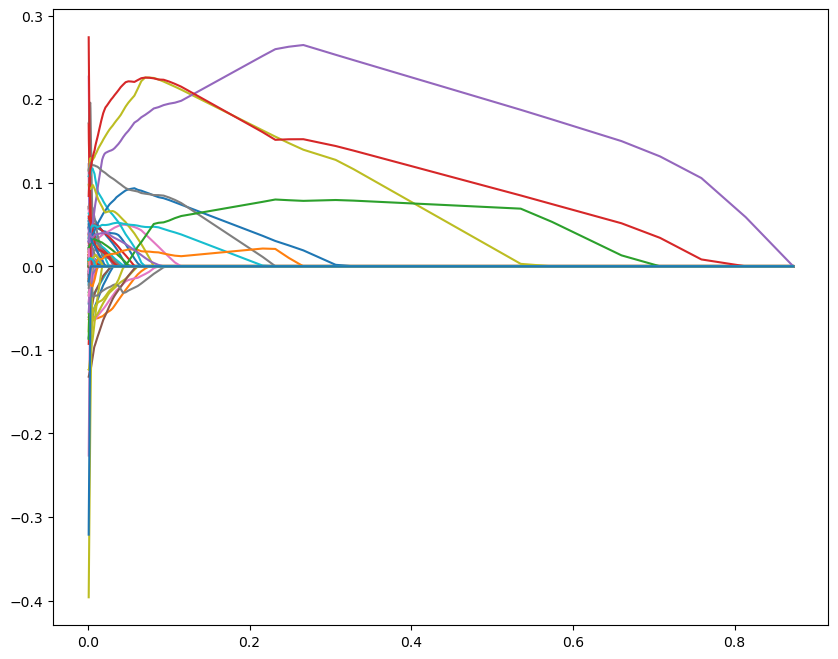

In [12]:
# compute the path
[alphas,weights,c] = Lasso.path(X1_std, Y1_std.ravel())

# plot the path
fig, ax = plt.subplots()
ax.plot(alphas, weights.T)
plt.show()

##### 2.4.1.1 Estimating the Model (Own implementation)

**You can ignore section 2.4.1.1 and jump to the implementation with `statsmodels` in section 2.4.1.2.**

We could of course use the predicted values produced by Lasso directly. To relate the exercise to the last tutorial, we will estimate `post-Lasso` instead. Since Lasso produces biased estimates, this will also allow us to conduct hypothesis tests based on the coefficients and standard errors. In short, we used Lasso as a feature selection device and will estimate an OLS model on the set of variables that remain in the active set under the optimal Lasso parameter. 

To find the set of variables that are included, we can simply look at the coefficients under the optimal parameter. We can then use a logical index to extract the columns that Lasso sets unequal to 0. 

In [13]:
X1_reduced = X1[:,Lasso.coef_ != 0]

Let's now use our OLS class from the previous tutorial to estimate the model.

In [14]:
class OLS:

    """
    This code implements a simple OLS regression. The inputs Y and X must be in numpy matrix format. 
    """
    
    def __init__(self, Y, X):
        #Initialize the dependent and independent variables
        self.Y, self.X = Y, X 
        
        # terminate and produce error message, if Y or X are of wrong type
        if isinstance(X,np.ndarray) == False:
            raise TypeError('X is not a numpy ndarray!')
        if isinstance(Y,np.ndarray) == False:
            raise TypeError('Y is not a numpy ndarray!')
    
    # here I moved the actual regression into its own function to streamline the bootstrap code
    def get_betas(self, YY, XX):
        
        #Estimate the beta coefficients
        return np.linalg.inv(XX.T @ XX) @ (XX.T @ YY)
    
    
    def estimate(self, se_method = 'standard', B = 1000):
        
        #unpack Y and X
        Y, X = self.Y, self.X
        
        # If not input is given, we simply use standard standard errors. It is useful to also print a message to 
        # to make users aware of the standard_errors used
        print("Standard Errors computed using method:", se_method)
        
        # run the OLS regression by calling the get_betas() function
        self.beta = self.get_betas(Y, X)
        
        # return the fitted values
        self.Y_hat = X @ self.beta
        
        # return regression residuals
        self.eps = Y - X @ self.beta
        
        # compute R^2
        MSE = np.mean(np.square(self.eps),axis=0)
        self.R2 = 1 - MSE/np.var(Y)

        
        # ------------------------------------------------------------------------------------------------------
        
        if se_method == 'standard':
            #compute the regression residuals
            eps = Y - X @ self.beta
        
            #compute the residual variance
            s_hat = 1/(Y.shape[0] - self.beta.shape[0]) * eps.T @ eps
            
            #compute the standard errors
            self.se = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * s_hat.item())).reshape((self.beta.shape[0],1))
            
            #compute confidence intervals
            CI_upper = self.beta + stats.norm.ppf(0.975)*self.se
            CI_lower = self.beta - stats.norm.ppf(0.975)*self.se
        
        elif se_method == 'bootstrap':
            print("Number of Bootstrap samples:", B)
            
            # initialize the array of bootstrap estimates
            self.bootstrapbeta = np.empty([self.beta.shape[0],B])
            
            # compute the coefficients over the bootstrap sample
            for i in range(B):
                
                # generate a vector of randomly drawn indices with replacement
                random_indices = np.random.choice(Y.shape[0], size=Y.shape[0], replace=True)
                
                # select the corresponding rows of Y and X
                Y_b = Y[random_indices]
                X_b = X[random_indices]
                
                # compute the regression coefficients for the bootstrap samples
                beta = self.get_betas(Y_b, X_b)
                
                # collect all bootstrap coefficients
                self.bootstrapbeta[:,i] = beta.ravel()
                
            # compute bootstrap standard errors
            self.se = np.sqrt(np.mean(np.square(self.bootstrapbeta-self.beta),axis=1)).reshape((self.beta.shape[0],1))
        
            #compute the bootstrap confidence intervals
            CI_upper = self.beta + 2*self.se
            CI_lower = self.beta - 2*self.se
        
        # ------------------------------------------------------------------------------------------------------
        
        #compute t-statistic for standard hypothesis test
        t = np.abs(self.beta/self.se)

        #compute p-values for standard hypothesis test
        p_vals = 2*(1-stats.norm.cdf(np.abs(t)))
        
        #generate an output table
        outmat = np.concatenate((self.beta,self.se,t,p_vals,CI_lower,CI_upper),axis=1)
        table = pd.DataFrame(outmat)
        table.columns =['beta', 'se','t-statistic','p-value','CI - lower','CI - upper'] 
        
        return table
    
    def hypothesis_test(self,i,β_0):
        # here a small if statement tests whether estimates have been computed before. If not, we simply call the
        # "estimate" function of our class
        if hasattr(self, 'beta'):
            beta, se = self.beta, self.se
            print("Previous estimates available. Hypothesis test is conducted based on previous estimates.")
        else:
            self.estimate()
            beta, se = self.beta, self.se
            print("No previous estimates available. Estimating OLS to obtain coefficients.")
        
        
        # compute the test statistic
        t = np.abs((beta[i] - β_0)/se.T[i])
        
        #compute p-values
        p_vals = 2*(1-stats.norm.cdf(np.abs(t)))
        
        # create output table
        outmat = np.concatenate((t,p_vals),axis=1)
        table = pd.DataFrame(outmat)
        table.columns =['t-statistic','p-value']
        
        return table

We now define regression objects of this class and estimate the model.

In [15]:
reg1 = OLS(Y1[:,None], X1_reduced)
reg1.estimate('standard')

Standard Errors computed using method: standard


,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,-7.070503e-02,0.038916,1.816884,0.069235,-0.146978,0.005568
1,-1.103403e-01,0.042892,2.572496,0.010097,-0.194408,-0.026273
2,-9.566273e-03,0.004331,2.208896,0.027182,-0.018054,-0.001078
3,6.848810e-03,0.004519,1.515529,0.129639,-0.002008,0.015706
4,5.782476e-07,0.000001,0.543415,0.586844,-0.000002,0.000003
5,2.244090e-04,0.000193,1.163920,0.244457,-0.000153,0.000602
6,1.901294e-02,0.009454,2.011164,0.044308,0.000484,0.037542
7,1.039679e-01,0.043962,2.364960,0.018032,0.017804,0.190131
8,-1.680219e-04,0.000091,1.850913,0.064182,-0.000346,0.000010
9,-1.403608e-03,0.000486,2.889811,0.003855,-0.002356,-0.000452


Not all the variables are statistically significant. 

**Question:**
* Why do you think that is? If Lasso conducts variable selection, why aren't the remaining variables statistically significant? 

##### 2.4.1.2 Estimating the Model (implementation with `statsmodels`)

We could of course use the predicted values produced by Lasso directly. To relate the exercise to the last tutorial, we will estimate `post-Lasso` instead. Since Lasso produces biased estimates, this will also allow us to conduct hypothesis tests based on the coefficients and standard errors. In short, we used Lasso as a feature selection device and will estimate an OLS model on the set of variables that remain in the active set under the optimal Lasso parameter. 

To find the set of variables that are included, we can simply look at the coefficients under the optimal parameter. We can then use a logical index to extract the columns that Lasso sets unequal to 0. 

In [16]:
# read out the variables selected by Lasso
X1_reduced = X1[:,Lasso.coef_ != 0]

# run the regression
model = sm.OLS(Y1[:,None], X1_reduced)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              270.7
Date:                Mon, 31 Oct 2022   Prob (F-statistic):                   1.71e-223
Time:                        15:36:56   Log-Likelihood:                          1853.3
No. Observations:                 370   AIC:                                     -3637.
Df Residuals:                     335   BIC:                                     -3500.
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0707      0.039     -1.817      0.070      -0.147       0.006
x2            -0.1103      0.043     -2.572      0.011      -0.195      -0.026
x3            -0.0096      0.004     -2.209      0.028      -0.018      -0.001
x4             0.0068      0.005      1.516      0.131      -0.002       0.016
x5          5.782e-07   1.06e-06      0.543      0.587   -1.51e-06    2.67e-06
x6             0.0002      0.000      1.164      0.245      -0.000       0.001
x7             0.0190      0.009      2.011      0.045       0.000       0.038
x8             0.1040      0.044      2.365      0.019       0.017       0.190
x9            -0.0002   9.08e-05     -1.851      0.065      -0.000    1.05e-05
x10           -0.0014      0.000     -2.890      0.004      -0.002      -0.000
x11            0.0009      0.000      1.946      0.052   -9.49e-06       0.002
x12            0.0012      0.001      2.075      0.039    6.17e-05       0.002
x13            0.0005      0.000      1.265      0.207      -0.000       0.001
x14            0.0120      0.010      1.196      0.233      -0.008       0.032
x15           -0.0077      0.005     -1.425      0.155      -0.018       0.003
x16            0.0127      0.016      0.792      0.429      -0.019       0.044
x17            0.0255      0.022      1.148      0.252      -0.018       0.069
x18            0.0117      0.006      1.821      0.070      -0.001       0.024
x19           -0.5335      0.121     -4.398      0.000      -0.772      -0.295
x20            0.0052      0.003      1.890      0.060      -0.000       0.011
x21            0.0004      0.000      1.533      0.126      -0.000       0.001
x22           -0.0004      0.001     -0.779      0.437      -0.001       0.001
x23           -0.0002      0.000     -0.341      0.733      -0.001       0.001
x24            0.0695      0.057      1.224      0.222      -0.042       0.181
x25            0.0512      0.047      1.100      0.272      -0.040       0.143
x26            0.0153      0.017      0.881      0.379      -0.019       0.049
x27            0.0019      0.001      1.726      0.085      -0.000       0.004
x28            0.0076      0.003      2.454      0.015       0.002       0.014
x29            0.1034      0.085      1.217      0.225      -0.064       0.271
x30            0.1146      0.028      4.093      0.000       0.060       0.170
x31            0.0419      0.043      0.963      0.336      -0.044       0.127
x32            0.0427      0.021      2.000      0.046       0.001       0.085
x33            0.0104      0.047      0.220      0.826      -0.082       0.103
x34            0.1084      0.078      1.394      0.164      -0.045       0.261
x35            0.0439      0.024      1.810      0.071      -

Not all the variables are statistically significant. 

**Question:**
* Why do you think that is? If Lasso conducts variable selection, why aren't the remaining variables statistically significant? 

##### 2.4.2 Sample 2

Let us now proceed with the second sample. We proceed as before and fit Lasso with the `LassoCV` class.

*Note, I had to increase the number of maximum iterations for convergence to be achieved.

In [17]:
# define the LassoCV object
Lasso2 = LassoCV(cv=5, fit_intercept=False, max_iter=10000).fit(X2_std, Y2_std.ravel())
print('The optimal alpha is: '+ str(Lasso2.alpha_))

The optimal alpha is: 0.02513119996973817


Let's again look at the Lasso paths.

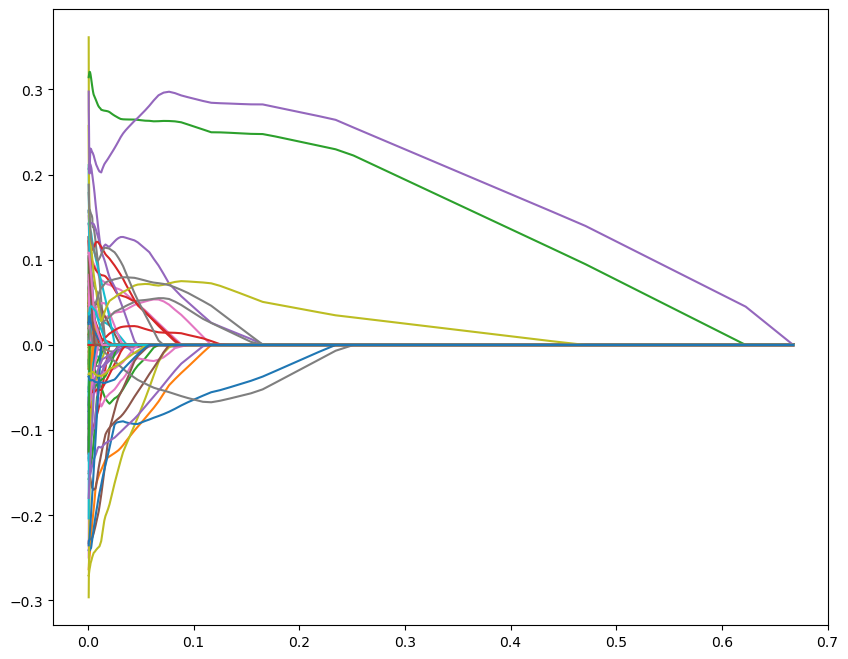

In [18]:
# compute the path
[alphas,weights,c] = Lasso2.path(X2_std, Y2_std.ravel(), max_iter=10000)

# plot the path
fig, ax = plt.subplots()
ax.plot(alphas, weights.T)
plt.show()

**Question:**
* What do you notice comparing the paths from the first and second sample? Why do you think this is?


##### 2.4.2.1 Estimating the model (Own implementation)

**You can ignore section 2.4.2.1 and jump to the implementation with `statsmodels` in section 3.4.2.2.**

Let's again turn to the post-Lasso estimates. 

In [19]:
# read out the set of remaining features

X2_reduced = X2[:,Lasso2.coef_ != 0]

# estimate OLS
reg2 = OLS(Y2[:,None], X2_reduced)
reg2.estimate('standard')

Standard Errors computed using method: standard


,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,-6.349894e-02,1.502865e-02,4.225191,2.387379e-05,-9.295456e-02,-0.034043
1,1.701069e-02,1.072553e-02,1.586001,1.127392e-01,-4.010954e-03,0.038032
2,-3.712182e-02,1.815486e-02,2.044732,4.088130e-02,-7.270468e-02,-0.001539
3,-5.903188e-03,1.256195e-02,0.469926,6.384077e-01,-3.052415e-02,0.018718
4,7.504676e-03,2.189590e-03,3.427434,6.093154e-04,3.213157e-03,0.011796
5,1.670353e-04,5.411411e-03,0.030867,9.753754e-01,-1.043914e-02,0.010773
6,5.361427e-07,4.107127e-07,1.305396,1.917580e-01,-2.688394e-07,0.000001
7,-7.975324e-05,1.179342e-04,0.676252,4.988808e-01,-3.109001e-04,0.000151
8,3.090829e-04,1.236413e-03,0.249984,8.026000e-01,-2.114241e-03,0.002732
9,1.182030e-04,7.066946e-04,0.167262,8.671640e-01,-1.266893e-03,0.001503


##### 2.4.2.2 Estimating the model (implementation with `statsmodels`)

Let's again turn to the OLS model.

First, we have to extract the remaining features. 

In [20]:
# read out the set of remaining features
X2_reduced = X2[:,Lasso2.coef_ != 0]

# run the regression
model = sm.OLS(Y2[:,None], X2_reduced)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.884
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              70.61
Date:                Mon, 31 Oct 2022   Prob (F-statistic):                   6.66e-134
Time:                        15:36:58   Log-Likelihood:                          1869.6
No. Observations:                 369   AIC:                                     -3667.
Df Residuals:                     333   BIC:                                     -3526.
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0635      0.015     -4.225      0.000      -0.093      -0.034
x2             0.0170      0.011      1.586      0.114      -0.004       0.038
x3            -0.0371      0.018     -2.045      0.042      -0.073      -0.001
x4            -0.0059      0.013     -0.470      0.639      -0.031       0.019
x5             0.0075      0.002      3.427      0.001       0.003       0.012
x6             0.0002      0.005      0.031      0.975      -0.010       0.011
x7          5.361e-07   4.11e-07      1.305      0.193   -2.72e-07    1.34e-06
x8         -7.975e-05      0.000     -0.676      0.499      -0.000       0.000
x9             0.0003      0.001      0.250      0.803      -0.002       0.003
x10            0.0001      0.001      0.167      0.867      -0.001       0.002
x11            0.0013      0.001      1.610      0.108      -0.000       0.003
x12        -6.888e-05      0.001     -0.099      0.921      -0.001       0.001
x13           -0.0072      0.003     -2.630      0.009      -0.013      -0.002
x14            0.0455      0.013      3.556      0.000       0.020       0.071
x15            0.0603      0.027      2.245      0.025       0.007       0.113
x16           -0.0292      0.009     -3.222      0.001      -0.047      -0.011
x17            0.0105      0.009      1.220      0.223      -0.006       0.027
x18           -0.1317      0.032     -4.142      0.000      -0.194      -0.069
x19            0.0122      0.004      2.854      0.005       0.004       0.021
x20           -0.0044      0.001     -3.350      0.001      -0.007      -0.002
x21           -0.3042      0.081     -3.756      0.000      -0.464      -0.145
x22           -0.0007      0.003     -0.226      0.821      -0.007       0.006
x23            0.0019      0.001      3.361      0.001       0.001       0.003
x24           -0.0010      0.001     -1.371      0.171      -0.002       0.000
x25        -6.974e-05    7.2e-05     -0.968      0.334      -0.000    7.19e-05
x26           -0.0157      0.004     -4.004      0.000      -0.023      -0.008
x27           -0.0021      0.007     -0.316      0.752      -0.015       0.011
x28            0.0220      0.020      1.075      0.283      -0.018       0.062
x29            0.0055      0.001      6.025      0.000       0.004       0.007
x30        -5.706e-05      0.002     -0.031      0.975      -0.004       0.004
x31            0.1361      0.047      2.913      0.004       0.044       0.228
x32            0.1090      0.031      3.532      0.000       0.048       0.170
x33           -0.0203      0.037     -0.544      0.587      -0.094       0.053
x34            0.0337      0.013      2.566      0.011       0.008       0.060
x35           -0.0026      0.003     -0.897      0.370      -

**Question:**
* How many variables remain in the active set now? Is there a difference compared to the first sample?
* Are all variables statistically significant now?

To gain some additional insight, let's check which variables are included in the active set in both samples:

In [21]:
vars_ = df_trans.drop(['PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA'], axis=1)

active_set = pd.DataFrame(index=vars_.columns,columns=['sample1', 'sample2'])
active_set['sample1'] = Lasso.coef_ != 0;
active_set['sample2'] = Lasso2.coef_ != 0;

active_set

,sample1,sample2
RPI,True,False
W875RX1,True,True
DPCERA3M086SBEA,False,False
CMRMTSPLx,False,False
RETAILx,False,True
...,...,...
CES3000000008,False,False
MZMSL,False,True
DTCOLNVHFNM,False,True
DTCTHFNM,False,False


**Questions:**
* Are the selected variables the same across samples? Why/why not? 
* What does this tell you about the robustness of the selected model over time? 
* How might this be related to (a) the properties of Lasso (hint: What does Lasso do with highly correlated predictors), (b) the length of the sample period, or (c) model breakdown and change? 

### 3.0 Interpretation

* As we discussed last week, there is a fundamental difference between forecasting and regression. In forecasting we are not interested in the significance of variables, rather we are interested in predictions of an outcome! That said, in forecasting we are happy to nudge the bias-variance trade-off in our favor:

    * **Recall:** *This is related to the concepts of over- and underfitting. Underfitting means that when we train a model on training data, but keep it way too simple, it does not generalize well. Essentially, we leave a lot of useful information unexploited. As an extreme case, imagine we just use a constant and essentially draw a straight line through the data. In this case the bias is large. Overfitting on the other hand occurs when we make our model way to complex. As an extreme case, imagine that we had one dummy for each observation and thus hit every data point perfectly. In this case the variance of the prediction is very high and again the model does not generalize well. We simply take into account too much noise or information that is related to a single data point, but tells little about other data.* 
    
    * As we discussed, in forecasting we are happy to get biased estimates, if they improve our forecasts! Lasso and other so-called shrinkage methods aim to optimize the bias-variance tradeoff by introducing bias. Conceptually, as the coefficients are shrunk/biased towards zero, they will likely underestimate the population parameters and consequently differ from OLS. At the same time, this will reduce the variance and alleviate the overfitting problem! As long as the second effect is bigger than the first, Lasso will produce better out-of-sample predictions. Cross-validation helps us to choose the degree by how much we want to bias the estimates. In essence, it helps find the sweet spot where the bias-variance trade-off is optimized. 
    
    * This means that we do not care about statistical significance of a model's coefficients! On the contrary, in regressions we want unbiased/consistent estimates of a model coefficients. The objective is thus completely different and using Lasso does not guarantee selecting variable that are statistically significant. To see this in more detail, recall the loss function behind Lasso:
    
$$
min_{\beta\in\mathbb{R}} \left\{ \frac{1}{N}|| y-X\beta ||^2_2 + \lambda ||\beta||_1 \right\}
$$

Conversely, we also face issues if we wanted to apply Lasso to Causal Inference tasks:

* In regression problems it might be useful to include variables as control variables even if they are not significant. This, e.g., avoids omitted variable biases. Usually we are only concerned with estimating the coefficient(s) of (a) certain specific variable(s) and thus the statistical significance of the control variables is not important. That said, as researchers we often have ideas about which variables should be included as control variables (for example by economic theory). Selection techniques such as plain Lasso cannot take these into account. We might hence be left with a set of variables that might seem counterintuitive after running model selection. While being automatic, these procedures thus do not take care of the thinking for us!

* In regression, the quantitative size of an estimate is also important. Besides the statistical significance we need to ask ourselves whether the estimate is quantitatively sizable enough to be considered economically significant!

How can we explain why Lasso selects a different set of predictors for both samples?
* Of course, we are dealing with a rather finite sample, so sampling variability is going to affect our estimates.
* In case of highly correlated input data, Lasso tends to drop one indicator vs. the other somewhat randomly. When estimating it on different samples, we might hence also get a slightly different outcome.
* In the literature there is ample evidence of model breakdown, model change, and "pockets of predictability". I.e. as e.g. the structure of the economy changes over time the "optimal" forecasting model is also going to change. Forecasting models thus generally require maintenance! 


### 4.0 Digression: Lasso in Causal Inference - A brief primer

One question remains: Are there ways of "fixing" Lasso such that we can use it in Causal Inference tasks nonetheless? This is actually a very active field of research and definitely worth a look, if you think about applying machine learning to causal inference tasks. 

The overall question is: How to select a model, i.e. subset of $x$?

Briefly summarizing: 
* Classic econometrics:
    * Use OLS and include covariates based on theory or inference
    * Problem how to delete covariates systematically? Adjust for multiple hypothesis testing?

* Machine learning:
    * Use LASSO to perform covariate selection
    * Note - estimates are biased towards zero!
        * Problem we omit potentially relevant variables!!
        * LASSO excludes possible confounders if little predictive power

Excluded variables may still have an effect through, e.g. covariates correlated with treatment.

#### 4.1 An example Problem: Treatment Effect Estimation

Let's look at a causal inference problem through the lens of treatment effect estimation. As an example, image that we were interested in estimating the effect of government corona relief packages on company lay-offs, where a copany's program eligibility depends on unknown observables. Following [Chernozhukov et al. (2018)](http://economics.mit.edu/files/12538), let's assume that we have the following data generating process
\begin{align}
y=& T\theta_0+g_0(X)+U\\
T=&m_0(X) + V\\
E[U|X,T]=&0\\
E[V|X]=&0\\
\end{align}

Basic model properties:
- The outcome $y$ is confounded by unknown nuisance function $g_0(\cdot)$ 
- The treatment $T$ suffer from selection on observable, where $m_0$ is  unknown propensity function
  - Note assumed no selection on unobservables (only "mild" econometric problem)
  
#### 4.2 A first attempt at fixing the Lasso:  
  
A simple solution was suggested by [Belloni et al. (2015)](https://doi.org/10.1257/jep.28.2.29) us to use Post-LASSO to correct for bias:
- Step 1: estimate two LASSO models
    - a) Regress $y_i$ on $x_i$ 
    - b) Regress $T_i$ on $x_i$ 
- Step 2: run OLS using only variables that were kept in either LASSOs

**Question:**
* Can you see potential problems with this procedure (hint: There are of course more than one issue, but what could potentially happen in very large dimension)?
  
#### 4.3 The Frisch-Waugh-Lovell Theorem:

The FWL states:

If a regression is
$$
y = X_1\beta_1 + X_2\beta_2 + u
$$

where $X_1$ and $X_2$ are $n\times k_1$ and $n\times k_2$, respectively and where $\beta_1$ and $\beta_2$ are conformable, then the estimate of $\beta_2$ will be the same as the estimate of it from the modified regression:

$$
M_{X_1}y = M_{X_1}X_2\beta_2 + M_{X_1}u 
$$

where $M_{X_1}$

$$
M_{X_1} = I-X_1(X_1'X_1)^{-1}X_1'
$$

that is:
$$
(y-X_1(X_1'X_1)^{-1}X_1'y) = (X_2-X_1(X_1'X_1)^{-1}X_1'X_2)\beta_2 + (u-X_1(X_1'X_1)^{-1}X_1'u) 
$$

where $(y-X_1(X_1'X_1)^{-1}X_1'y)$ and $(X_2-X_1(X_1'X_1)^{-1}X_1'X_2)$ are the residuals from a regression of $y$ on $X_1$ and $X_2$ on $X_1$, respectively.  

**Question:**
* Any idea of how this could help us? 

#### 4.4 Fixing the Lasso II: Linear Double Machine Learning

[Chernozhukov et al. (2015)](https://doi.org/10.1257/aer.p20151022) states the following algorithm for :

1. run the two LASSO equations (as in POST-LASSO) and obtain residuals 
  - $\hat{\rho}_i^y$ from $y_i$ on $x_i$
  - $\hat{\rho}_i^d$ from $T_i$ on $x_i$
1. run a regression of $\hat{\rho}_i^y$ on $\hat{\rho}_i^d$

- Similar to Frisch-Waugh-Lowell where we partial out effects.
  - We partial out effect of $x_i$ on both $y_i$ and on $T_i$ seperately 
- Innovation: We make double selection of variables using LASSO

**Question:**
* Can you spot a problem with this? 

The issue is that we are going to systematically bias $\hat{g}$, because we are counteracting overfitting with regularization.
* To solve this issue, [Chernozhukov et al. (2018)](http://economics.mit.edu/files/12538) estimate $\hat{g}$ and $\hat{m}$ on an auxiliary subsample $I^c$. The first major contribution is that in general the second `double debiasing` procedure leads to consistent estimates and can be used estimate average treatment effects!
    * The proof depends on sample splitting - using an independent auxiliary sample for estimating $\hat{m}_0,\hat{g}_0$.
* To gain efficient estimates [Chernozhukov et al. (2018)](http://economics.mit.edu/files/12538) rotate the auxiliary sample using **cross-fitting**: first use one part as auxiliary sample, then the other. Like cross-validation. This is second major contribution.

Generally, the procedure is even more flexible:
We can estimate $\hat{m}_0,\hat{g}_0$ using cross-validation on auxiliary sample $I^c$ with e.g.:
* linear/logistic models, including regularized
* tree based inclding random forests, boosted trees
* neural networks 
* kernel models including suppert vector machine 

In the paper, [Chernozhukov et al. (2018)](http://economics.mit.edu/files/12538) also extend the procedure to
* IV regression
* Local average treatment effects

If you are generally interested in these kinds of things, you should also have a look at `Causal Trees` and `Causal Forests`proposed by Athey et. al (2016, 2018). 

# Lecture 2 - Part 2

### 5.0 Preparing the quarterly data

To start off, we read in the quarterly data instead. The approach to data cleaning is the same. So let's again transform the data and drop the missing observations.

In [22]:
# read-in the .csv file
df = pd.read_csv('current_Q.csv')

# store the transformation information for later
df_transform = df.iloc[1,:]

# delete the first two rows as they contain meta-information
df = df.iloc[2:,:]

# transform the date series into datetime values
df['sasdate'] = df['sasdate'].astype('datetime64[ns]') 

# set the dates as new index
df = df.set_index('sasdate')

# display the data 
df.head()

,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-03-01,3121.936,1923.675,76.6269,1228.2525,708.5994,340.604,340.5050,49.2784,169.8803,229.2229,...,315394.42,267125.60,2292458.21,1977.06,1674.49,118.0697,55.5167,59.1400,3.1765,18.6211
1959-06-01,3192.380,1953.384,79.5107,1246.6236,714.4575,367.099,351.0348,50.7534,174.7639,237.2364,...,327311.61,273793.60,2300595.72,1973.28,1650.63,119.5468,57.5067,61.5867,3.1012,19.2899
1959-09-01,3194.653,1973.791,81.0481,1263.5122,717.2159,343.391,354.7551,52.4063,179.4710,232.7918,...,335783.49,275597.47,2300248.57,1964.47,1612.36,121.8384,58.7300,63.0600,3.0720,18.9544
1959-12-01,3203.759,1976.014,77.1760,1278.8229,721.6332,354.567,350.6404,52.3002,178.9702,226.2014,...,330686.41,255408.94,2294980.79,1964.29,1517.14,129.4733,57.7633,62.0200,3.1572,17.8221
1960-03-01,3275.757,1994.918,79.6590,1290.4392,723.4440,390.210,362.3523,54.1198,185.1905,233.1615,...,343374.65,279155.40,2316152.76,1972.78,1603.82,123.0048,56.2767,60.1933,3.3850,16.8284


In [23]:
# create an emptyh copy of the dataframe, where the indices and column names are the same
df_trans = pd.DataFrame(index=df.index, columns=df.columns)

# loop over the columns of the dataframe 
for i in range(0,df.shape[1]):
    
    # transform data to 'levels', i.e. no change
    if df_transform[i+1] == 1:
        df_trans[df.columns[i]] = df[df.columns[i]]
    
    # transform data to 'first differences'
    elif df_transform[i+1] == 2:
        df_trans[df.columns[i]] = df[df.columns[i]].diff()
    
    # transform data to 'second differences'
    elif df_transform[i+1] == 3:
        df_trans[df.columns[i]] = df[df.columns[i]].diff(periods=2)
        
    # transform data to 'log-levels'
    elif df_transform[i+1] == 4:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]])
        
    # transform data to 'log-differences'
    elif df_transform[i+1] == 5:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]]).diff()
    
    # transform data to 'second log-differences'
    elif df_transform[i+1] == 6:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]]).diff(periods=2)
    
    # transform data to 'percentage changes'
    elif df_transform[i+1] == 7:
        df_trans[df.columns[i]] = df[df.columns[i]].pct_change()

        
# here I simply use the df_transform series and the fact that Python reads if statements from top to bottom.
# Checking for two missing values must hence be done first.

# check whether the transformation code contains 2nd differences or 2nd log-differences
if 3 in df_transform.unique() or 6 in df_transform.unique():
    
    # print a message
    print('two missing values at the beginning detected. Deleted the first two rows.')
    # drop the first two observations
    df_trans = df_trans.iloc[2:,:]

# check whether the transformation code contains 1st differences or 1st log-differences or pct. changes
elif 2 in df_transform.unique() or 5 in df_transform.unique() or 7 in df_transform.unique():
    
    # print a meassage
    print('one missing values at the beginning detected. Deleted the first row.')
    
    # drop the first observation
    df_trans = df_trans.iloc[1:,:]

# drop missing values at the end of the sample     
df_trans = df_trans.iloc[:-2,:]

# drop columns with missing values
df_trans = df_trans.dropna(axis='columns')
print('remaining number of variables: ' + str(df_trans.shape[1]))

# dispaly the final data set
df_trans

two missing values at the beginning detected. Deleted the first two rows.
remaining number of variables: 210


,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-09-01,0.000712,0.010393,0.019151,0.013457,0.003853,-0.066762,0.010542,0.032048,0.026578,-0.018913,...,0.025554,275597.47,-0.000151,-0.004475,-38.27,0.018988,0.021049,0.023641,-0.0292,-0.017546
1959-12-01,0.002846,0.001126,-0.048954,0.012045,0.006140,0.032028,-0.011666,-0.002027,-0.002794,-0.028719,...,-0.015296,255408.94,-0.002293,-0.000092,-95.22,0.060779,-0.016597,-0.016630,0.0852,-0.061597
1960-03-01,0.022224,0.009521,0.031666,0.009043,0.002506,0.095788,0.032856,0.034200,0.034166,0.030306,...,0.037652,279155.40,0.009183,0.004313,86.68,-0.051251,-0.026073,-0.029896,0.2278,-0.057371
1960-06-01,-0.005408,0.012535,0.022501,0.011003,0.010896,-0.097837,-0.018342,0.016711,0.014503,-0.085422,...,0.018321,280144.95,0.003057,0.000375,-22.94,0.014782,-0.003680,-0.006778,0.0876,-0.024349
1960-09-01,0.004881,-0.004005,-0.008030,-0.001174,-0.005880,-0.002544,-0.021666,-0.044133,-0.017656,-0.030290,...,0.018804,275164.71,0.007952,0.006017,-47.83,0.036742,-0.006262,-0.012285,0.0276,0.001369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,0.006349,0.006681,0.015371,0.005070,0.007590,0.004583,0.006045,-0.004234,0.004623,0.011187,...,0.011539,398824.64,0.013479,0.014888,-7.95,0.029245,0.025918,0.025926,-0.0106,0.004262
2019-12-01,0.005845,0.003927,0.007677,0.005070,-0.001881,-0.009445,0.002433,-0.004197,-0.000867,0.014121,...,0.006991,399935.49,0.004337,0.002409,-0.99,0.004210,0.042307,0.041578,-0.0445,0.035684
2020-03-01,-0.012707,-0.017776,-0.033525,-0.025903,0.017201,-0.023522,-0.003480,-0.041300,-0.017286,0.043444,...,0.018236,440651.07,0.010621,0.005037,47.95,-0.078714,-0.005570,0.004679,0.0698,-0.009700


Before we proceed, we again split the data into a training and a test sample for out-of-sample forecasting.

In [24]:
# conduct a sample split
df_trans_is = df_trans.loc['1959-09-01':'1989-12-01']
df_trans_oos = df_trans.loc['1990-01-01':]

### 6.0 Estimation:

**Question:**
* Why should we always standardize the data before applying techniques like Lasso, Ridge, or PCA?


Lasso for example, places a penalty on the size of the coefficients. They should hence be on the same scale, as otherwise certain variables might dominate the analysis. Principal Components Analysis (PCA) works with the variance-covariance matrix of the data. The size of the coefficients again depends on the scale of the variables. Before using regularization techniques like Lasso or Ridge-regression or dimensionality reduction techniques like Principal Component Analysis (PCA), one should hence standardize the input variables.


In [25]:
from sklearn.preprocessing import StandardScaler

# initialize the class
dt_std_is = StandardScaler()
dt_std_oos = StandardScaler()
dt_std_full = StandardScaler()

# compute mean and std. used for computing the z-score
dt_std_is.fit(df_trans_is)
dt_std_oos.fit(df_trans_oos)
dt_std_full.fit(df_trans)

# generate and empty dataframe with the same index and columns as df_trans
df_std_is = pd.DataFrame(index=df_trans_is.index, columns=df_trans_is.columns)
df_std_oos = pd.DataFrame(index=df_trans_oos.index, columns=df_trans_oos.columns)
df_std_full = pd.DataFrame(index=df_trans.index, columns=df_trans.columns)

# filld dataframe with standardized data
df_std_is.iloc[:,:] = dt_std_is.transform(df_trans_is)
df_std_oos.iloc[:,:] = dt_std_oos.transform(df_trans_oos)
df_std_full.iloc[:,:] = dt_std_full.transform(df_trans)
df_std_is

,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-09-01,-0.827181,0.165514,0.184578,0.782724,-0.344032,-1.621471,0.009646,0.630888,0.660363,-0.459508,...,0.855415,-0.024799,-1.194756,-1.242417,-0.609325,0.122459,0.103672,0.133033,-0.115945,-0.197943
1959-12-01,-0.606875,-1.046225,-1.76878,0.475368,-0.046663,0.465959,-0.951176,-0.559327,-0.711402,-0.645565,...,-2.618148,-0.654209,-1.485284,-0.753417,-1.738525,1.028546,-0.510552,-0.503357,0.330585,-0.785438
1960-03-01,1.393074,0.051555,0.543534,-0.178226,-0.519232,1.813217,0.974993,0.706046,1.014747,0.474338,...,1.884107,0.086125,0.071355,-0.26202,1.868174,-1.400403,-0.665159,-0.713001,0.887187,-0.729084
1960-06-01,-1.458837,0.445639,0.280646,0.248572,0.571777,-2.278101,-1.239969,0.095171,0.096439,-1.721425,...,0.240367,0.116976,-0.759669,-0.701352,-0.305363,0.031282,-0.299797,-0.347668,0.339953,-0.288673
1960-09-01,-0.3969,-1.717068,-0.595017,-2.402397,-1.609784,-0.26454,-1.383768,-2.030077,-1.405495,-0.675387,...,0.281464,-0.038291,-0.095653,-0.071919,-0.79888,0.507385,-0.341925,-0.434701,0.105759,0.054314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988-12-01,0.465521,0.284894,0.368983,-0.319619,0.503266,0.10923,0.063584,-0.046841,0.064939,0.022686,...,-0.132337,1.578264,-0.126088,-0.212024,-0.078532,0.176809,0.244019,0.239267,-0.037881,-0.756634
1989-03-01,0.143278,-0.588176,-0.492637,-0.662052,-0.257558,0.494493,-0.062021,-0.072325,0.161329,-0.283273,...,-1.007526,2.372912,-0.640526,-0.288613,1.208895,-1.837448,0.668073,0.678894,-0.398149,-0.245961
1989-06-01,-0.115876,-0.584477,0.015535,-1.266311,-0.644553,-0.416169,-0.390063,0.256825,0.046201,-0.70341,...,-0.877837,2.04534,-0.771613,-0.529927,-0.330743,0.478955,0.981784,0.868489,-0.585505,0.085978


### 2.1 Lasso & Ridge-Regression:

**Question:**
* What are the differences between Lasso and Ridge Regression? 

The difference between Lasso and Ridge-regression lies in the penalty term. While Lasso penalizes the sum of absolute coefficients, Ridge-regression penalizes the sum of squared coefficients. This has two major implications. 
First, due to the absolute term, we cannot compute first order conditions of Lasso. It thus does not have an analytical solution and we have to resort to numerical methods to solve the optimization problem. For Ridge-Regression, however, an analytical solution does exist. 

The Second implication becomes obvious in the figure below. Here a convex set (depicted by the red line) lies tangent to the constraint regions of Lasso and Ridge-Regression, respectively. For Lasso this set is likely to hit a corner of the constraint region which results in coefficients that are exactly zero. In case of Ridge-Regression, however, the tangent is equally likely to hit a point for which the coefficients are zero or any other point. This is why Lasso can result in coefficients that are exactly zero, while Ridge-Regression generally does not. 

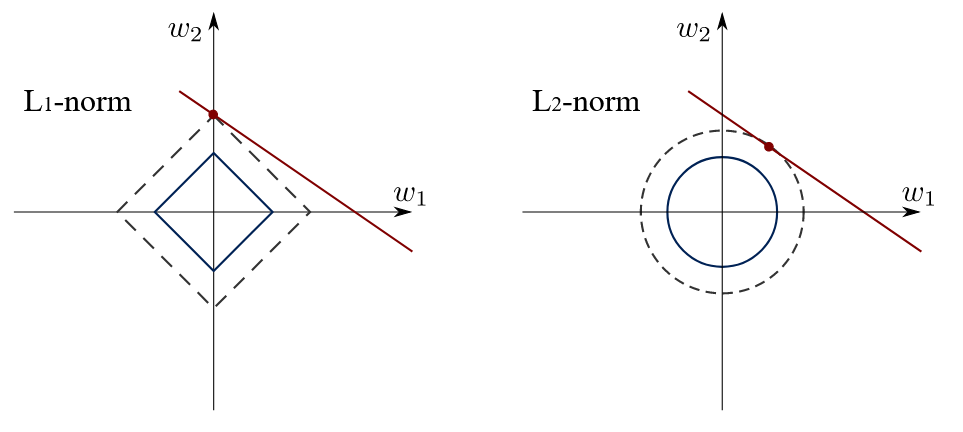

In [26]:
Image(filename = "Lasso_ridge.png")

Source: [Wikipedia](https://en.wikipedia.org/wiki/Lasso_(statistics))

#### 6.1.1 Lasso:

Let's again run Lasso using Python's `scikit-learn` library for the following exercises. 

In [27]:
# import Lasso with cross-validation
from sklearn.linear_model import LassoCV

# define the LassoCV object
Lasso = LassoCV(cv=5, fit_intercept=False).fit(df_std_is.iloc[:,1:], df_std_is.iloc[:,0])
print('The optimal alpha is: '+ str(Lasso.alpha_))

The optimal alpha is: 0.0046194187341294475


Let's again look at the path of the coefficients.

In [28]:
# compute the path
[alphas,weights,c] = Lasso.path(df_std_is.iloc[:,1:], df_std_is.iloc[:,0])

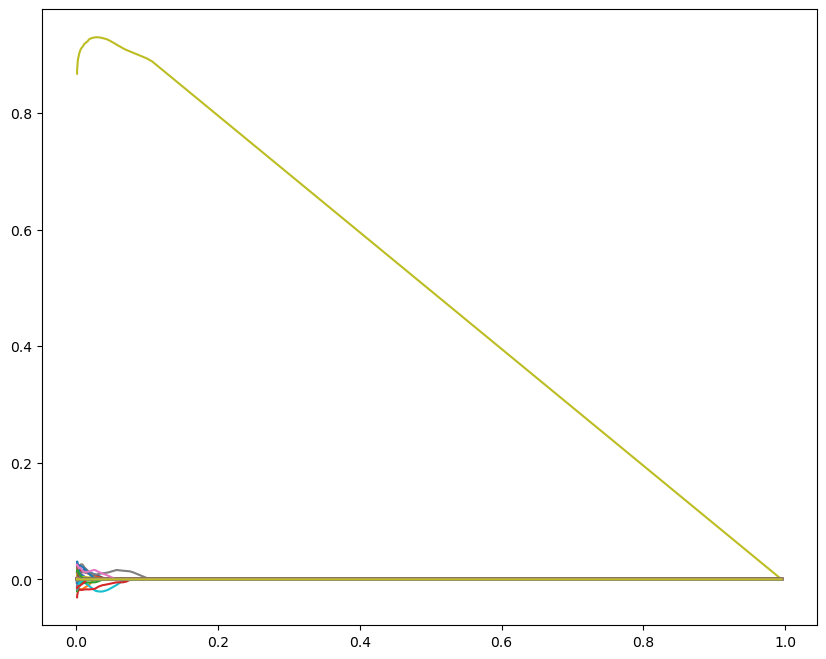

In [29]:
# plot the path
fig, ax = plt.subplots()
ax.plot(alphas, weights.T)
plt.show()

We can also display the parameters in a historgam to get an idea of the distribution of the parameters.

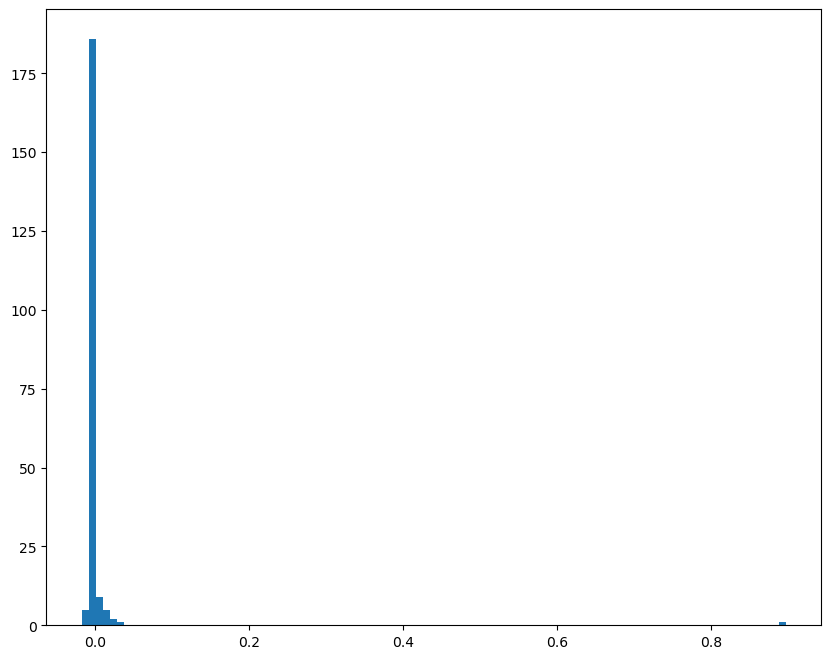

In [30]:
# plot a histogram of the model parameters
plt.hist(Lasso.coef_, bins = 100)
plt.show()

**Question**
* Is there anything that stands regarding the coefficients size?

Finally, let's compute the in-sample and out-of-sample predictions. Before, we can reverse the standardization so that we are back to the original scaling. **Importantly**, note that we are using the coefficients estimated in sample to compute out-of-sample predictions!

In [31]:
# compute the Lasso in-sample predictions
y_hat_Lasso_is = Lasso.predict(df_std_is.iloc[:,1:])

# compute the Lasso out-of-sample predictions
y_hat_Lasso_oos = Lasso.predict(df_std_oos.iloc[:,1:])

# de-standardize the in-sample predictions and the outcome
y_ht_Lasso_is = y_hat_Lasso_is*np.sqrt(dt_std_is.var_[0])+dt_std_is.mean_[0]
y_yt_Lasso = np.asarray(df_std_full.iloc[:,0])*np.sqrt(dt_std_full.var_[0])+dt_std_full.mean_[0]

# de-standardize the out-of-sample predictions
y_ht_Lasso_oos = y_hat_Lasso_oos*np.sqrt(dt_std_oos.var_[0])+dt_std_oos.mean_[0]

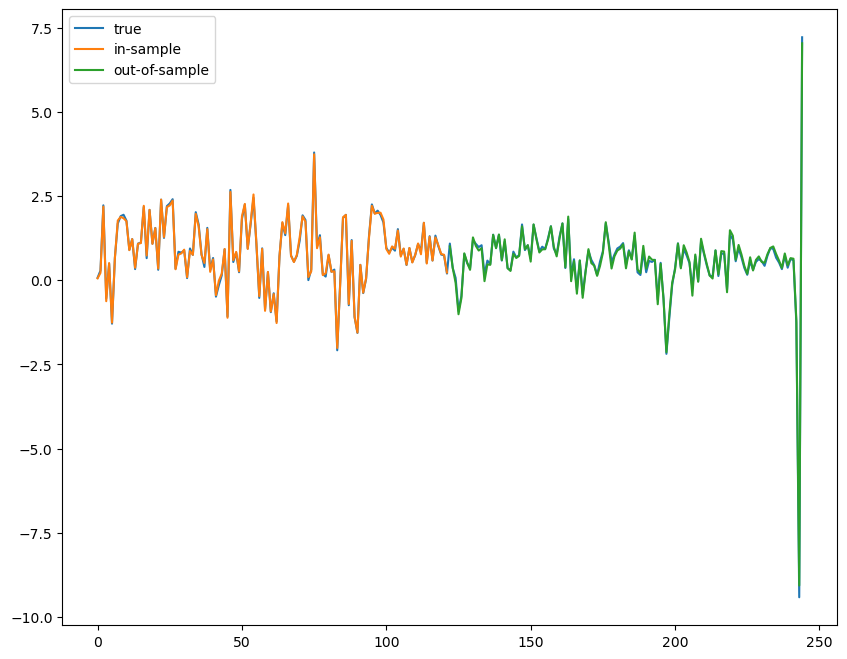

In [32]:
# Plot the Lasso prediction and the original data
fig, ax = plt.subplots()
plt.plot(np.vstack((y_yt_Lasso*100,np.hstack((y_ht_Lasso_is*100,[None]*(len(y_yt_Lasso)-len(y_ht_Lasso_is)))),np.hstack(([None]*(len(y_yt_Lasso)-len(y_ht_Lasso_oos)),y_ht_Lasso_oos*100,)))).T)
ax.legend(['true','in-sample','out-of-sample'])
plt.show()

**Question:**
* What do you notice?

#### 6.1.2 Ridge-Regression:

##### 6.1.2.1 Own Implementation

As pointed out above, there is an analytical solution for Ridge-Regression: 

$$
\hat{\beta_R} = (X'X + \lambda I)^{-1} X'Y
$$

With $\lambda=0$, we are back to the general OLS estimator. Before we use a `scikit-learn` implementation, let's write our own Ridge-Regression `class` for illustrative purposes. The `scikit-learn` implementation also does not allow us to retrieve the paths of the coefficients. We will endow our procedure with the necessary functionality such that we can compare the Ridge solution to the Lasso solution.

In [33]:
class Ridge:

    """
    This code implements a simple Ridge-regression. The inputs Y and X must be in numpy array format. 
    """
    
    def __init__(self, Y, X):
        #Initialize the dependent and independent variables
        self.Y, self.X = Y, X 
        
        # terminate and produce error message, if Y or X are of wrong type
        if isinstance(X,np.ndarray) == False:
            raise TypeError('X is not a numpy ndarray!')
        if isinstance(Y,np.ndarray) == False:
            raise TypeError('Y is not a numpy ndarray!')
    
    # this is the function computing the coefficients for Ridge-regression
    def get_betas(self, λ, YY=None, XX=None):
        
        if YY is None:
            YY = self.Y
        
        if XX is None:
            XX = self.X
        
        XX = XX.astype(np.float64)
        YY = YY.astype(np.float64)
        
        #Estimate the beta coefficients
        self.beta = np.linalg.inv(XX.T @ XX + λ * np.eye(XX.shape[1])) @ (XX.T @ YY)
        
        self.y_hat = XX @ self.beta
        
        return self.beta
    
    # this function computes the paths of the coefficients given a grid of λs
    def beta_paths(self, grid, YY=None, XX=None):
        
        if YY is None:
            YY = self.Y
        
        if XX is None:
            XX = self.X
        
        # initialize an empty array for the paths of beta
        betas = np.empty([XX.shape[1],len(grid)])
        
        for i in range(len(grid)):
            
            # compute the betas for every grid point
            betas[:,i] = self.get_betas(grid[i], YY, XX)
            
        # store the paths
        self.betas = betas
        
        
    def CV(self, grid ,k=5):
        
        # unpack self
        Y, X = self.Y, self.X
        
        # generate arrays containing the indices of the k data chunks
        ids = list(range(len(Y)))
        chunks = np.asarray(np.array_split(np.array(ids),k),dtype=object)

        # read out the sample size
        n = list(range(len(Y)))

        # convert k into a list
        a = np.arange(k)

        # initialize out-of-sample loss
        MSE_oos = []

        # iterate over the folds to compute the CV standard error
        for i in a:

            # obtain the indeces of the data belonging to the training sample
            b_train = a[np.arange(len(a))!=i]
            subid_train = np.concatenate( chunks[b_train], axis=0 )

            # obtain the indices of the data belonging to the test sample
            b_test =  a[np.arange(len(a)) ==i]
            subid_test = np.concatenate( chunks[b_test], axis=0 )

            # devide the data into test and training samples
            Y_train = Y[subid_train]
            X_train = X[subid_train,:]
            Y_test = Y[subid_test]
            X_test = X[subid_test,:]

            # calculate the coefficient paths
            self.beta_paths(grid, Y_train, X_train)
            estimate_train = self.betas
            
            # compute the out-of-sample error
            error_oos = np.repeat(Y_test.reshape(len(Y_test),1),len(grid),axis=1) - X_test @ estimate_train
            
            # compute the MSE for each λ
            MSE_oos.append(np.mean(np.square(error_oos),axis=0))
            
        # transform to array
        MSE_oos = np.asarray(MSE_oos)
        
        # Compute expected MSE for each λ 
        self.E_MSE = np.mean(MSE_oos,0)
        
        # find λ with lowest E_MSE  
        self.lambda_ = grid[np.argmin(self.E_MSE)]
        
        # get path for lowest lambda
        self.beta_ = self.get_betas(grid[np.argmin(self.E_MSE)])
        

Let's define a `Ridge-class` object and run the Ridge Regression.

In [34]:
# define an object of class ridge (our own)
R1 = Ridge(np.asarray(df_std_is.iloc[:,0]),np.asarray(df_std_is.iloc[:,1:]))

Let's look at the paths for the coefficients.

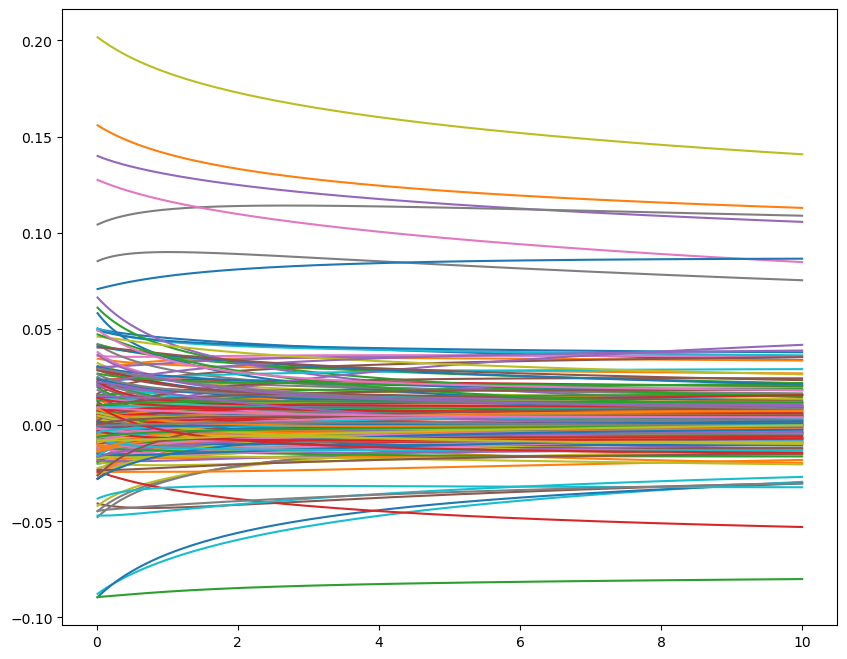

In [35]:
λs = np.arange(0.0,10.01,0.01)
R1.beta_paths(λs)

# Plot the Path of the Ridge-Regression coefficients
fig, ax = plt.subplots()
plt.plot(λs[1:], R1.betas[:,1:].T)
plt.show()

**Question:**
* Compare the Ridge-paths with the Lasso-paths. What do you notice? 

Let us now call the `CV` method to tune the $\lambda$ parameter with 5-fold cross-validation. 

In [36]:
R1.CV(λs)
print('The optimal λ is: ' + str(R1.lambda_))

The optimal λ is: 4.15


Recall what we learned last week. We can can also plot the expected MSE/out-of-sample loss across the grid.

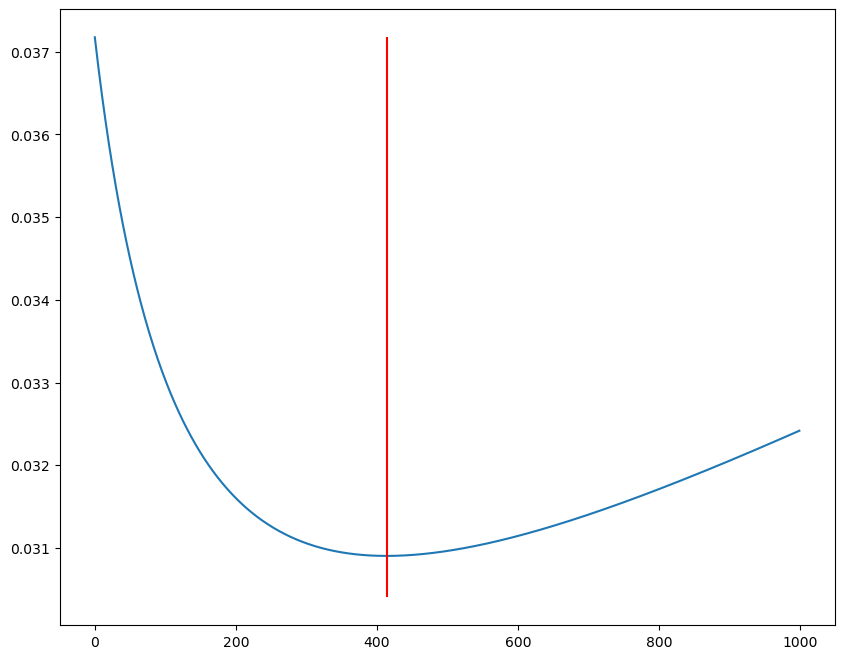

In [37]:
# Plot the Ridge prediction and the original data
fig, ax = plt.subplots()
plt.plot(R1.E_MSE[1:])
plt.vlines(np.argmin(R1.E_MSE[1:]), np.min(R1.E_MSE[1:])-0.0005, np.max(R1.E_MSE[1:]), colors='r', linestyles='solid')
plt.show()

First of all: How cool is that?! 

**Question:**
* What do you notice in terms of the optimal $\lambda$ after CV? Where do we land in terms of expected out-of-sample loss? What does this imply for the bias-variance tradeoff? 

Finally, let us again compute the de-standardized predictions and plot them together with the original data.

In [38]:
# de-standardize the in-sample predictions and the 
y_ht_R1_is = R1.y_hat*np.sqrt(dt_std_is.var_[0])+dt_std_is.mean_[0]

# de-standardize the outcome 
y_yt_R1 = np.asarray(df_std_full.iloc[:,0])*np.sqrt(dt_std_full.var_[0])+dt_std_full.mean_[0]

# generate out-of-sample predictions and de-standardize
y_hat_oos = df_std_oos.iloc[:,1:]@R1.beta_
y_ht_R1_oos = y_hat_oos*np.sqrt(dt_std_oos.var_[0])+dt_std_oos.mean_[0]


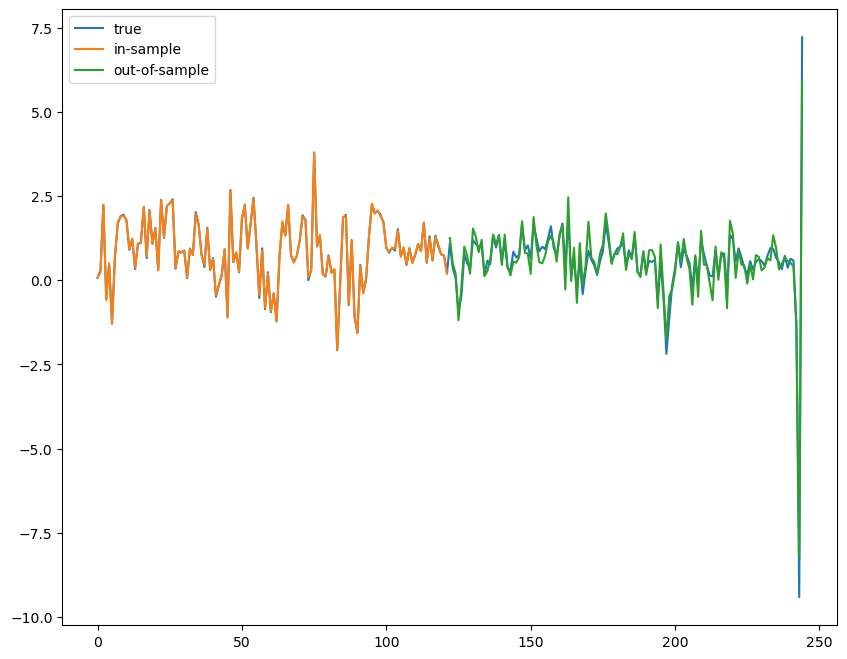

In [39]:
# Plot the Ridge prediction and the original data
fig, ax = plt.subplots()
plt.plot(np.vstack((y_yt_R1*100,np.hstack((y_ht_R1_is*100,[None]*(len(y_yt_R1)-len(y_ht_R1_is)))),np.hstack(([None]*(len(y_yt_R1)-len(y_ht_R1_oos)),y_ht_R1_oos*100,)))).T)
ax.legend(['true','in-sample','out-of-sample'])
plt.show()

**Question:**
* What do you observe? 

##### 6.1.2.2 Implementation using Scikit-learn:

In [40]:
# import Ridge with cross-validation
from sklearn.linear_model import RidgeCV

# define the LassoCV object
R2 = RidgeCV(cv=5, fit_intercept=False).fit(df_std_is.iloc[:,1:], df_std_is.iloc[:,0])
print('The optimal λ is: '+ str(R2.alpha_))

The optimal λ is: 10.0


Let's compute the predicted values and plot them together with the original data.

In [41]:
# compute the Lasso in-sample predictions
y_hat_R2_is = R2.predict(df_std_is.iloc[:,1:])
y_hat_R2_oos = R2.predict(df_std_oos.iloc[:,1:])

# de-standardize the in-sample predictions
y_ht_R2_is = y_hat_R2_is*np.sqrt(dt_std_is.var_[0])+dt_std_is.mean_[0]

# de-standardize the outcome
y_yt_R2 = np.asarray(df_std_full.iloc[:,0])*np.sqrt(dt_std_full.var_[0])+dt_std_full.mean_[0]

# de-standardize the out-of-sample predictions
y_ht_R2_oos = y_hat_R2_oos*np.sqrt(dt_std_oos.var_[0])+dt_std_oos.mean_[0]

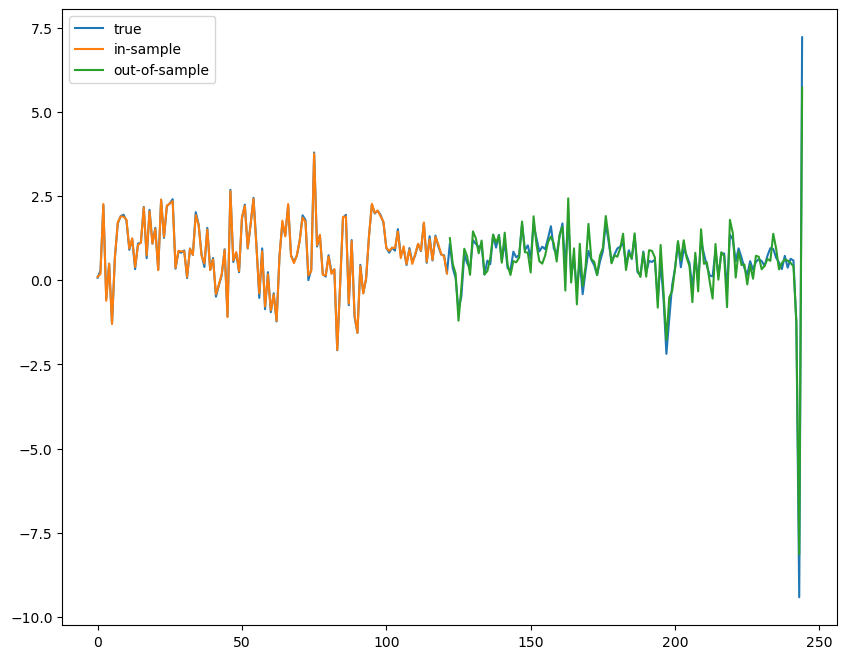

In [42]:
# Plot the Ridge prediction and the original data
fig, ax = plt.subplots()
plt.plot(np.vstack((y_yt_R2*100,np.hstack((y_ht_R2_is*100,[None]*(len(y_yt_R2)-len(y_ht_R2_is)))),np.hstack(([None]*(len(y_yt_R2)-len(y_ht_R2_oos)),y_ht_R2_oos*100,)))).T)
ax.legend(['true','in-sample','out-of-sample'])
plt.show()

Finally, let's check by how much the predictions from the package solution and our own computations differ.

In [43]:
print('The average difference in sample is: '+str(np.mean(y_ht_R1_is - y_ht_R2_is)))
print('The average difference out-of-sample is: '+str(np.mean(y_ht_R1_oos - y_ht_R2_oos)))

The average difference in sample is: -9.242379175286267e-20
The average difference out-of-sample is: -1.0577582170590287e-19


This is basically zero, i.e. our implementation and the package's give us the same result! 

### 6.2 Principal Component Analysis (PCA):

The idea for this exercise is to extract principal components from the independent variables and to use these later in a factor augmented regression (regressions, where the independent variables contain factors).

Let's again write our own class that implements PCA. To assess the optimal number of factors, let us also use cross-validation. Note that there are many techniques of varying degrees of sophistication to assess the optimal number of factors. Their performance might differ from application to application. The only reason I use CV here, is to preserve consistency among the three exercises. You are of course free to use e.g. `Scikit-learn` to estimate the factors or to use any other scheme to select the number of factors you like.

*Also note that it is customary to implement PCA using SVD instead of using the Eigendecomposition. I only do this here to stick to what is usually illustrated in textbooks.*

##### 6.2.1 Own Implementation

In [44]:
class PCA:
    
    def __init__(self, X):
        self.X = X

    def get_components(self, X = None, kk = 1, λ = None):
        
        # build the function such that it can also back out the factors given the loadings for arbitrary samples
        if X is None:
            X = self.X
            
        if λ is not None:
            # back out the size of the data
            [t,n] = X.shape
            
            self.λ = λ
            self.f = X @ self.λ /n
        else:
            #X = self.X
            X = X.astype(np.float64)
            
            # back out the size of the data
            [t,n] = X.shape

            # since the data is standardized, we can compute the variance-covariance matrix like so
            covm = X.T @ X

            # now we extract the eigenvectors and eigenvalues
            w,v = np.linalg.eig(covm)

            # sort in descending order
            sort_id = np.flipud(np.argsort(w))
            v = v[:,sort_id]
            # diagonalize eigenvalues
            w = np.diag(w[sort_id])
    
            # compute the factor loadings
            self.λ = np.sqrt(n)*v[:,0:kk]

            # compute the principal components
            self.f = X @ self.λ /n

        return self.f.real, self.λ.real
    
    def get_betas(self, Y, X = None, f = None, kk=1):
        
        if f is None:
        # extract kk factors
            f, l = self.get_components(X, kk) 
        
        f = f.astype(np.float64)
        
        # compute OLS coefficients in factor augmented regression
        betas = np.linalg.inv(f.T @ f) @ (f.T @ Y)
    
        return betas
        
    def get_predictions_CV(self, Y_train, Y_test, X_train, X_test, max_k):
        
        MSE = np.empty([1, max_k])
        
        for i in range(1,max_k+1):
            
            # compute principal components of training data
            f_train, λ_train = self.get_components(X_train, i)
            
            # compute the betas for the training data
            betas_train = self.get_betas(Y_train, None, f_train.real, i)
        
            # compute the factors for the test data based on the loading for the training data
            f_test, λ_test = self.get_components(X_test, i, λ_train.real)
            
            # compute the predictions of the test data
            y_hat_test = f_test @ betas_train
            
            # compute out-of-sample error of test data
            oos = Y_test - y_hat_test
            
            # compute MSE for oos
            MSE[0,i-1] = np.mean(oos**2)
            
        return MSE #, y_hat_test
            
    def CV(self, Y, X, max_k ,k=5):
        
        # generate arrays containing the indices of the k data chunks
        ids = list(range(len(Y)))
        chunks = np.asarray(np.array_split(np.array(ids),k),dtype=object)

        # read out the sample size
        n = list(range(len(Y)))

        # convert k into a list
        a = np.arange(k)

        # initialize out-of-sample loss
        MSE_oos = []

        # iterate over the folds to compute the CV standard error
        for i in a:

            # obtain the indeces of the data belonging to the training sample
            b_train = a[np.arange(len(a))!=i]
            subid_train = np.concatenate( chunks[b_train], axis=0 )

            # obtain the indices of the data belonging to the test sample
            b_test =  a[np.arange(len(a)) ==i]
            subid_test = np.concatenate( chunks[b_test], axis=0 )

            # devide the data into test and training samples
            Y_train = Y[subid_train]
            X_train = X[subid_train,:]
            Y_test = Y[subid_test]
            X_test = X[subid_test,:]

            # calculate the MSEs for all k
            MSE = self.get_predictions_CV(Y_train, Y_test, X_train, X_test, max_k)
            
            # compute the MSE for each λ
            MSE_oos.append(MSE)
            
        # transform to array
        MSE_oos = np.asarray(MSE_oos)
    
        # Compute expected MSE for each λ 
        self.E_MSE = np.mean(MSE_oos,0)
        
        # find k with lowest E_MSE  
        self.k_ = np.argmin(self.E_MSE)
        
        # get betas for optimal number of factors
        self.beta_ = self.get_betas(Y, X, None, self.k_)
        
        # get factors
        self.f_ = self.f
        
        # get predictions
        self.yhat_ = self.f_ @ self.beta_

Before we turn to out-of-sample forecasting, let us first build some intuition and use this class to extract factors/principal components for the entire sample.

In [45]:
%%capture

# define PCA class in-sample object
PCA1_full = PCA(np.asarray(df_std_full.iloc[:,1:]))

k = 3 
PCA1_full.get_components(np.asarray(df_std_full.iloc[:,1:]),k)

We can plot the three principal components that we just extracted together with the original data. This gives us an idea of what kind of information they might contain and how well they fit the GDP series.

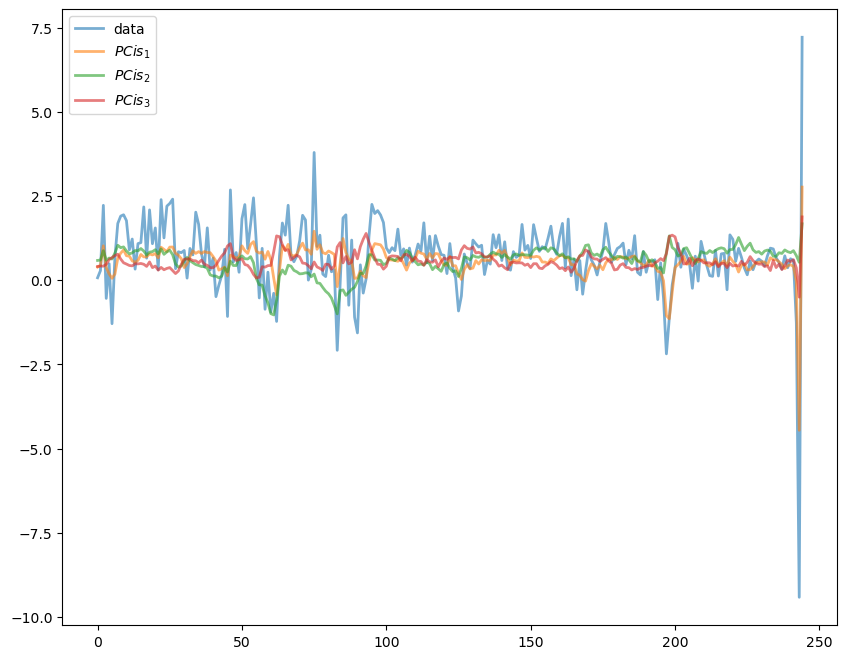

In [46]:
f_PCA1_full = PCA1_full.f.real*np.sqrt(dt_std_is.var_[0])+dt_std_oos.mean_[0]

fig, ax = plt.subplots()

ax.plot(y_yt_R2*100, linewidth=2, alpha=0.6, label='data')
for i in range(k):
    current_label = f'$PC is_{i+1}$'
    ax.plot(f_PCA1_full[:,i]*100, linewidth=2, alpha=0.6, label=current_label)
ax.legend()
plt.show()

**Question:**
* Do you have any intuition of what the factors might resemble? 


Let us now use CV to assess the optimal number of factors. The problem is that we assess performance with OLS. We have fewer observations than variables, however. I thus limit the maximal number of factors to 100.

In [47]:
k_max = 100

PCA1_is = PCA(np.asarray(df_std_is.iloc[:,1:]))
PCA1_is.CV(np.asarray(df_std_is.iloc[:,0]),np.asarray(df_std_is.iloc[:,1:]),k_max,5)

print('The optimal number of factors is: ' + str(PCA1_is.k_))

The optimal number of factors is: 89


Again, we can look at the expected MSE for each CV step (number of factors). Note that I omitted the last three MSEs as they increase rapidly, blowing up the scale.

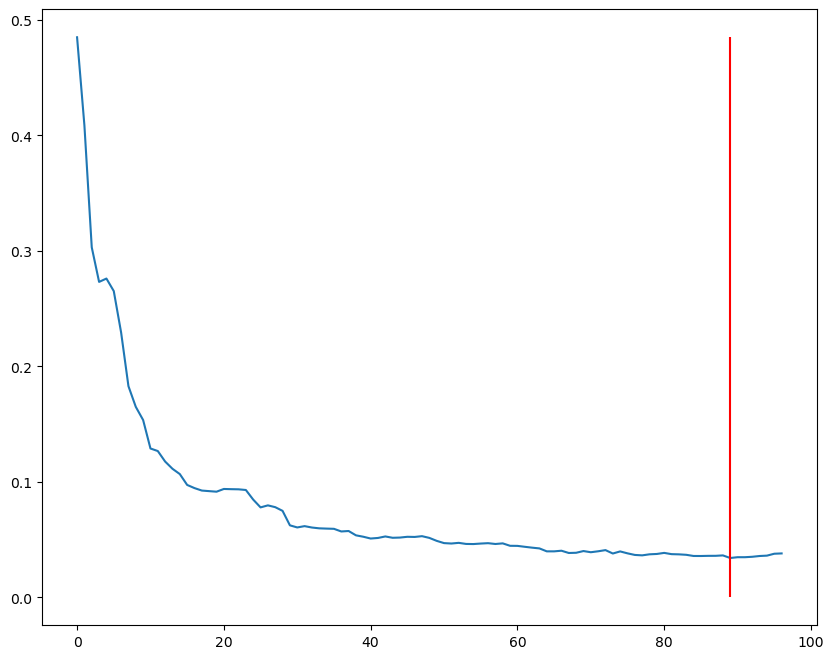

In [48]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Plot the Ridge prediction and the original data
fig, ax = plt.subplots()
plt.plot(PCA1_is.E_MSE.ravel()[:-3])
plt.vlines(89, 0, np.max(PCA1_is.E_MSE.ravel()[:-3]), colors='r', linestyles='solid')
plt.show()


Using the optimal number of factors, we can now plot the predictions together with the original data.

In [49]:
k = PCA1_is.k_

# compute the in-sample and out-of-sample factors
f_is, λ_is = PCA1_is.get_components(np.asarray(df_std_is.iloc[:,1:]),k)
f_oos, λ_oos = PCA1_is.get_components(np.asarray(df_std_oos.iloc[:,1:]),None, λ_is)

beta_is = PCA1_is.get_betas((df_std_is.iloc[:,0]), None, f_is, None)
beta_oos = PCA1_is.get_betas((df_std_oos.iloc[:,0]), None, f_oos, None)

y_hat_PCA1_is = f_is @ beta_is
y_hat_PCA1_oos = f_oos @ beta_oos

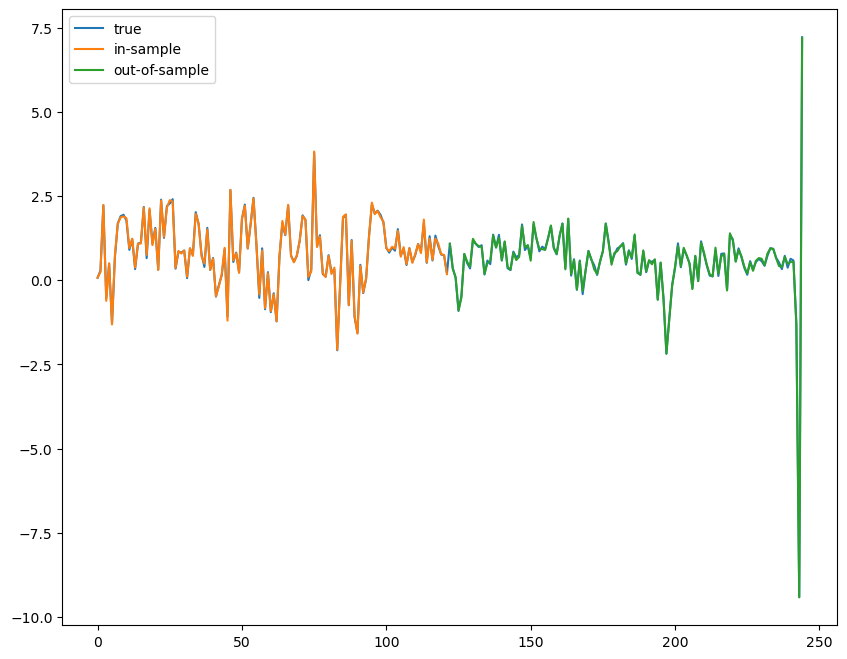

In [50]:
# de-standardize the in-sample predictions 
y_ht_PCA1_is = y_hat_PCA1_is*np.sqrt(dt_std_is.var_[0])+dt_std_is.mean_[0]
y_ht_PCA1_oos = y_hat_PCA1_oos*np.sqrt(dt_std_oos.var_[0])+dt_std_oos.mean_[0]

# Plot the PCA prediction and the original data
fig, ax = plt.subplots()
plt.plot(np.vstack((y_yt_R2*100,np.hstack((y_ht_PCA1_is*100,[None]*(len(y_yt_R2)-len(y_ht_PCA1_is)))),np.hstack(([None]*(len(y_yt_R2)-len(y_ht_PCA1_oos)),y_ht_PCA1_oos*100,)))).T)
ax.legend(['true','in-sample','out-of-sample'])
plt.show()

**Question:**
* What do you notice?

### 6.3: Digression - Is the economy sparse or dense?

We can of course conduct model selection merely based on forecast performance criteria. However, philosophically speaking assuming a factor model vs. e.g. a Lasso model also implies something about what we believe about the structure of our data: 
* A factor model commonly implies a dense structure. I.e. the panel of variables loads onto and is hence driven by a few common components. Conversely, the entire panel contains information about the factors which we then use as predictors in our forecasting regression. In short, we assume that all possible predictors are important for prediction even though their individual impact might be small. 
* Lasso on the other hand implies a sparse structure. I.e. only a few variables with non-zero loadings matter for our variables of interest and are hence important for prediction.

**Question/Discussion:**
* Do you believe the Macroeconomy to be sparse or dense? What about microeconomic data? What about financial data?

Let's look at some evidence:

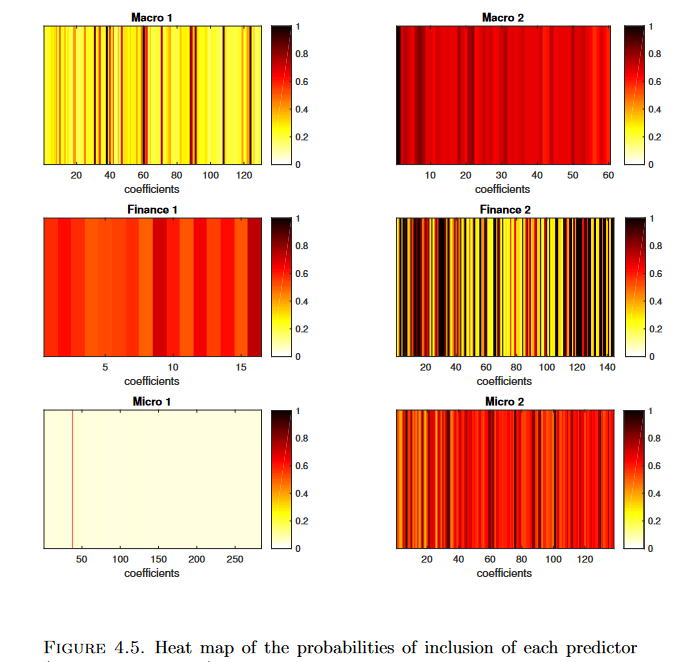

In [51]:
Image(filename = "illusion_of_sparsity.PNG")

*Source: Giannone et al. (2018), "Economic Predictions with Big Data: The Illusion of Sparsity". Federal Reserve Bank of New York, Staff Report No. 847.*

**Question:**
* what do you observe?

* Using an uninformative prior, apart from dataset "Micro 1", there is considerable uncertainty about each variables probability of inclusion. The data is thus not informative enough to uniquely identify predictors when a large pool of variables is available to the researcher. In consequence, the results are not compatible with the existence of a clear sparse representation of the predictive model.
* At the same time, if we assume a sparse structure ex-ante/a dogmatic prior, we usually also get a sparse representation of the data.

**Food for thought:**
* If we have a dogmatic prior, are we understating pervasive model uncertainty?

**Again: All these tools are super useful in practice. However, by using a certain method we are also always implying something about our beliefs about the world/population. Taking a step back, thinking deeply, and understanding this is key. Data Science is more than pressing buttons!**

### 7.0 Recession Forecasting and ROC curve:

In the last part of this tutorial, we are going look at ROC curves for all three models. First, we are going to find the actual recession in the sample (based on the GDP growth data). The idea then is to use all of the previous approaches and a cut-off rule (for contemporaneous GDP predictions), to produce a recession forecast. Note, this exercise is of course highly simplified/stylized. We are then going to compute the true-positive and false-positive rate to produce a ROC curve. 

First, however, we need to construct a variable that indicates whether the economy is in recession or not.

Before we test our models on a recession classification that is closer to the truth, let's assume the economy is in recession whenever growth is below 0%:


In [52]:
recession1 = []

for i in range(y_yt_R1.shape[0]-1):
    
    if y_yt_R1[i] < 0:
        recession1.append(1)
    else: 
        recession1.append(-1)
        
recession1.append(-1)

recession1_is = recession1[:y_ht_PCA1_is.shape[0]]
recession1_oos = recession1[y_ht_PCA1_is.shape[0]:]

This definition yields the following recession dates:

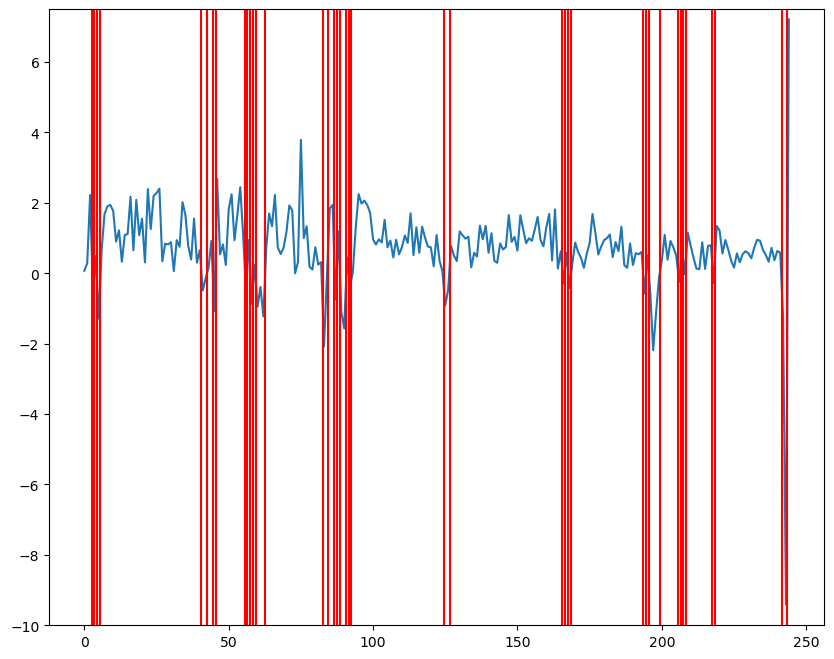

In [53]:
# plot the time periods with the recessions
fig, ax = plt.subplots()
ax.plot(y_yt_R1*100)
ax.plot(np.asarray(recession1).T*1000000, color='red')
ax.set_ylim([-10,7.5])
plt.show()

With the recessions classified, we can now compute the true-positive and false-positive rates of all three approaches, Lasso, Ridge, and PCA. For convenience, let's cast the computations into a function.

The idea is the following. All models produce predictions of GDP growth (Note that we could have used a binary classification model to predict recessions instead). The question now is, which cut-off level should we use to "convert" the GDP growth prediction into a recession forecast. It could for example be that we achieve better performance, if we only predict a recession, if a model predicts e.g. +0.2% or -0.5% GDP growth. Optimizing a cut-off thus let's us tweak the sensitivity of the model. For each of these cut-off levels, we then compute the true-positive and false-positive rates. 

In [54]:
def ROC(prediction, data):

    gammas = np.arange(max(prediction)+0.001,min(prediction)-0.001,-0.0001)

    TPR = []
    FPR = []
    for i in gammas:
        recs = prediction < i 
        match = data-recs

        #breakpoint()
        FP = sum(match == -2)
        TP = sum(match == 0)

        TPR.append(TP/(sum(np.asarray(data)==1)))
        FPR.append(FP/(sum(np.asarray(data)==-1)))
        
    return TPR, FPR

With the function in place, we can easily compute the ROCs for all models that we used above.

In [55]:
# call the function for all models
TPR_Lasso, FPR_Lasso = ROC(y_ht_Lasso_is, recession1_is)
TPR_R1, FPR_R1 = ROC(y_ht_R1_is, recession1_is)
TPR_PCA1, FPR_PCA1 = ROC(y_ht_PCA1_is, recession1_is)


Having called the function, we can now plot the ROCs.

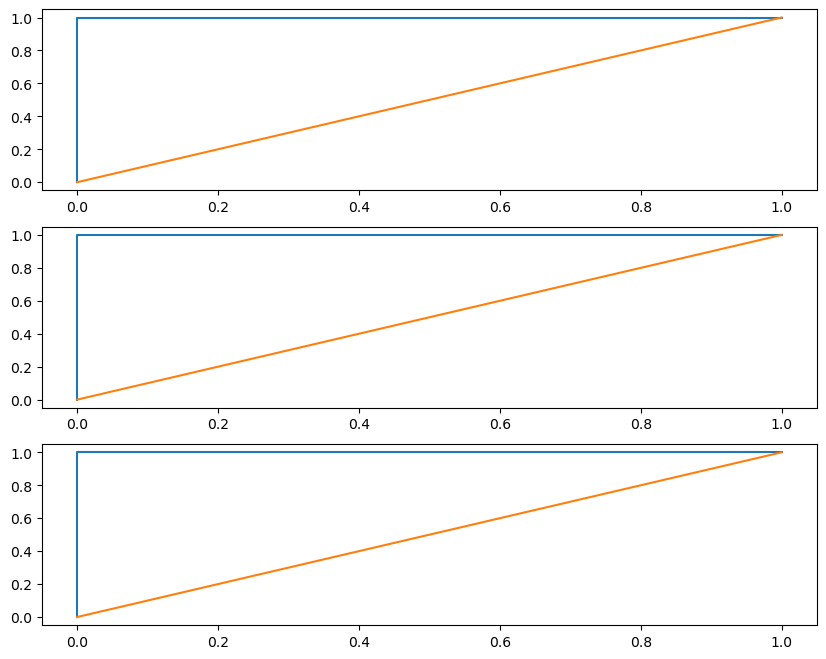

In [56]:
fig, ax = plt.subplots(3)
ax[0].plot(FPR_Lasso,TPR_Lasso)
ax[0].plot(FPR_Lasso,FPR_Lasso)
ax[1].plot(FPR_R1,TPR_R1)
ax[1].plot(FPR_R1,FPR_R1)
ax[2].plot(FPR_PCA1,TPR_PCA1)
ax[2].plot(FPR_PCA1,FPR_PCA1)
plt.show()

The above results are based on in-sample predictions and our very simple cut-off rule. In this case, all the models turn out to be perfect predictors of recessions. 

**Question:**
* Why do you think this is?

Let's instead use the out-of-sample predictions to test the models' out-of-sample performance.


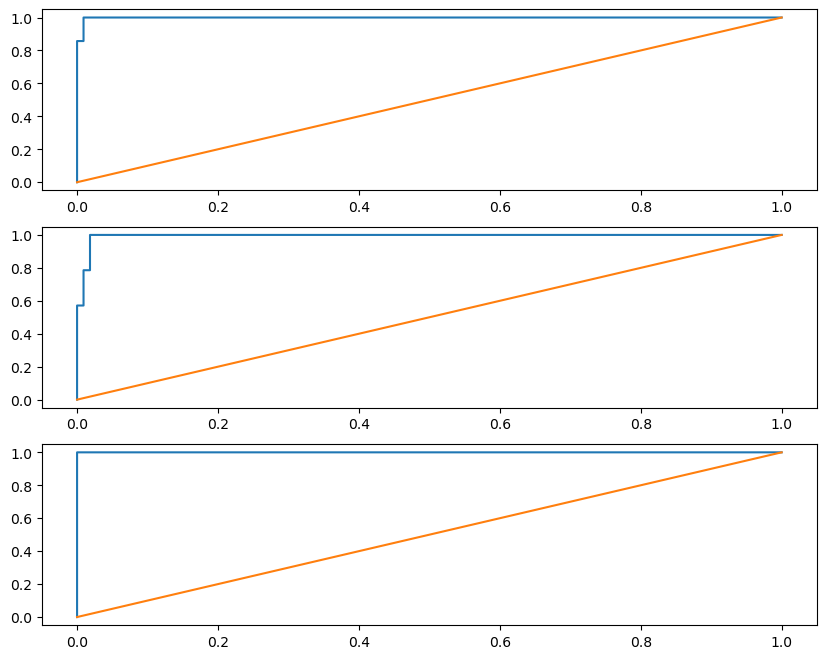

In [57]:
# call the function for all models
TPR_Lasso, FPR_Lasso = ROC(y_ht_Lasso_oos, recession1_oos)
TPR_R1, FPR_R1 = ROC(y_ht_R1_oos, recession1_oos)
TPR_PCA1, FPR_PCA1 = ROC(y_ht_PCA1_oos, recession1_oos)

fig, ax = plt.subplots(3)
ax[0].plot(FPR_Lasso,TPR_Lasso)
ax[0].plot(FPR_Lasso,FPR_Lasso)
ax[1].plot(FPR_R1,TPR_R1)
ax[1].plot(FPR_R1,FPR_R1)
ax[2].plot(FPR_PCA1,TPR_PCA1)
ax[2].plot(FPR_PCA1,FPR_PCA1)
plt.show()

**Question**
* What do you notice?

Now Lasso and Ridge perform slightly worse. PCA still is a perfect classifier. 

Let us now check what happens if we use a different classification rule. As a rule of thumb, in practice we often classify a recession as two consecutive quarters of negative GDP growth. Let's use this more realistic definition instead and evaluate how our models perform.

In [58]:
recession2 = []

for i in range(y_yt_R1.shape[0]-1):
    
    if y_yt_R1[i] < 0 and y_yt_R1[i+1] < 0:
        recession2.append(1)
    elif y_yt_R1[i-1] < 0 and y_yt_R1[i] < 0:
        recession2.append(1)
    else: 
        recession2.append(-1)
        
recession2.append(-1)

recession2_is = recession2[:y_ht_PCA1_is.shape[0]]
recession2_oos = recession2[y_ht_PCA1_is.shape[0]:]

indices = [i for i, x in enumerate(recession2) if x == 1]
indices

[41, 42, 60, 61, 62, 83, 84, 89, 90, 125, 126, 196, 197, 198, 199, 242, 243]

For illustration, let's again look at the data and the recessions following the new definition.

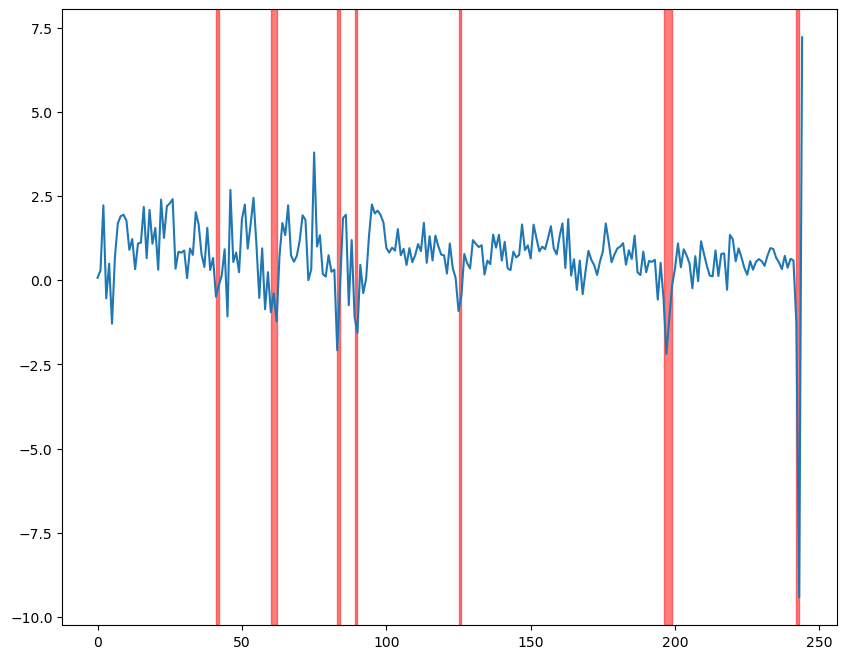

In [59]:
# plot a histogram of the model parameters
fig, ax = plt.subplots()
ax.plot(y_yt_R1*100)
ax.axvspan(41, 42, alpha=0.5, color='red')
ax.axvspan(60, 62, alpha=0.5, color='red')
ax.axvspan(83, 84, alpha=0.5, color='red')
ax.axvspan(89, 90, alpha=0.5, color='red')
ax.axvspan(125, 126, alpha=0.5, color='red')
ax.axvspan(196, 199, alpha=0.5, color='red')
ax.axvspan(242, 243, alpha=0.5, color='red')

**Question:**
* With this new definition, what do you expect to happen? Why? 

Again, compute the ROCs.

In [60]:
# call the function for all models
TPR_Lasso, FPR_Lasso = ROC(y_ht_Lasso_is, recession2_is)
TPR_R1, FPR_R1 = ROC(y_ht_R1_is, recession2_is)
TPR_PCA1, FPR_PCA1 = ROC(y_ht_PCA1_is, recession2_is)


Finally, plot the ROCS.

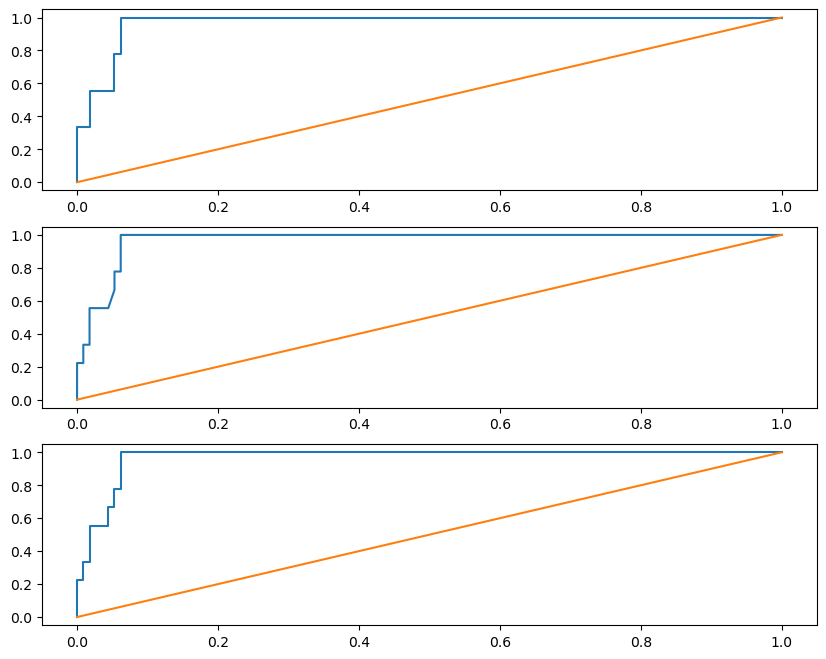

In [61]:
fig, ax = plt.subplots(3)
ax[0].plot(FPR_Lasso,TPR_Lasso)
ax[0].plot(FPR_Lasso,FPR_Lasso)
ax[1].plot(FPR_R1,TPR_R1)
ax[1].plot(FPR_R1,FPR_R1)
ax[2].plot(FPR_PCA1,TPR_PCA1)
ax[2].plot(FPR_PCA1,FPR_PCA1)
plt.show()

With the new definition, the models no longer classify recessions perfectly in-sample. They are, however, still far superior to e.g. a random classifier (the diagonal).

Let us again look at the out-of-sample performance. 

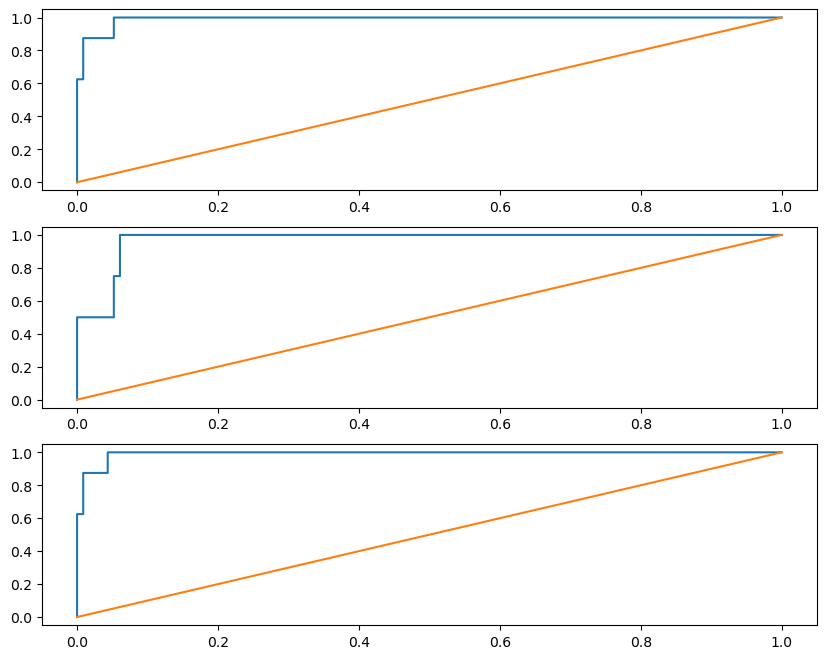

In [62]:
# call the function for all models
TPR_Lasso, FPR_Lasso = ROC(y_ht_Lasso_oos, recession2_oos)
TPR_R1, FPR_R1 = ROC(y_ht_R1_oos, recession2_oos)
TPR_PCA1, FPR_PCA1 = ROC(y_ht_PCA1_oos, recession2_oos)

fig, ax = plt.subplots(3)
ax[0].plot(FPR_Lasso,TPR_Lasso)
ax[0].plot(FPR_Lasso,FPR_Lasso)
ax[1].plot(FPR_R1,TPR_R1)
ax[1].plot(FPR_R1,FPR_R1)
ax[2].plot(FPR_PCA1,TPR_PCA1)
ax[2].plot(FPR_PCA1,FPR_PCA1)
plt.show()

All models do a good job out-of-sample as well. They do even slightly better than in-sample. 

**Question:**
* Any idea why that might be (hint: think about our in-sample vs. out-of-sample periods and data availability)?


There are only few recessions in the test sample. Essentially, there is very little data to evaluate our model on.

## Questions for Review:

* What is the difference between Lasso and Ridge-regression?
* Why does Lasso set coefficients to zero, while Ridge-regression generally does not?
* Why does Lasso not have a closed-form solution? Why does Ridge-regression have one?
* How does CV help us to optimize the bias-variance trade-off? 
* Why do we have to standardize the data before applying Lasso, Ridge-regression, or PCA?
* Can we generally interpret the principal components extracted with PCA?
* What does the ROC-curve display?
* What is the cut-off rule in this case?
* How do we compute true-positive and false-positive rates for our recession forecasts? (Not mathematically, rather the procedure)
* Why are all models perfect classifiers following the first definition for recessions? Why does this change using the second definition?